<a href="https://colab.research.google.com/github/Naman09746/Walmart-Sales-Forecast/blob/main/Walmart_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle -q

In [2]:
from google.colab import files
files.upload() # this will prompt you to upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"namanjoshi0313","key":"308f0818e56858c9a12d8736d28299f8"}'}

In [3]:
import os

# Create the necessary directory if it doesn't exist
os.makedirs('/root/.config/kaggle', exist_ok=True)

    # Move the kaggle.json file to the correct location
!mv kaggle.json /root/.config/kaggle/

In [4]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Set up the Kaggle API
api = KaggleApi()
api.authenticate()

# Define the dataset path and filenames (These are the filenames based on the dataset structure)
dataset_name = 'aslanahmedov/walmart-sales-forecast'  # Dataset name on Kaggle

# Download the entire dataset zip file (which includes all CSV files)
api.dataset_download_files(dataset_name, path='walmart_sales_data', unzip=True)

# List all files in the downloaded folder to check if all CSVs are downloaded
import os
data_dir = 'walmart_sales_data'
files = os.listdir(data_dir)
print("Downloaded files:", files)


Dataset URL: https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast
Downloaded files: ['features.csv', 'stores.csv', 'test.csv', 'train.csv']


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# **Data Loading and Initial Exploration**

In [6]:
# Load datasets
data_dir = 'walmart_sales_data'
features_df = pd.read_csv(f'{data_dir}/features.csv')
train_df = pd.read_csv(f'{data_dir}/train.csv')
test_df = pd.read_csv(f'{data_dir}/test.csv')
stores_df = pd.read_csv(f'{data_dir}/stores.csv')

# Convert date columns to datetime
features_df['Date'] = pd.to_datetime(features_df['Date'])
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Display dataset shapes
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Features shape: {features_df.shape}")
print(f"Stores shape: {stores_df.shape}")

# Examine data types and basic statistics
print("\nTrain Data Info:")
print(train_df.info())
print("\nFeatures Data Summary:")
print(features_df.describe())

Train shape: (421570, 5)
Test shape: (115064, 4)
Features shape: (8190, 12)
Stores shape: (45, 3)

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB
None

Features Data Summary:
             Store                 Date  Temperature   Fuel_Price  \
count  8190.000000                 8190  8190.000000  8190.000000   
mean     23.000000  2011-10-31 12:00:00    59.356198     3.405992   
min       1.000000  2010-02-05 00:00:00    -7.290000     2.472000   
25%      12.000000  2010-12-17 00

# **Enhanced EDA**

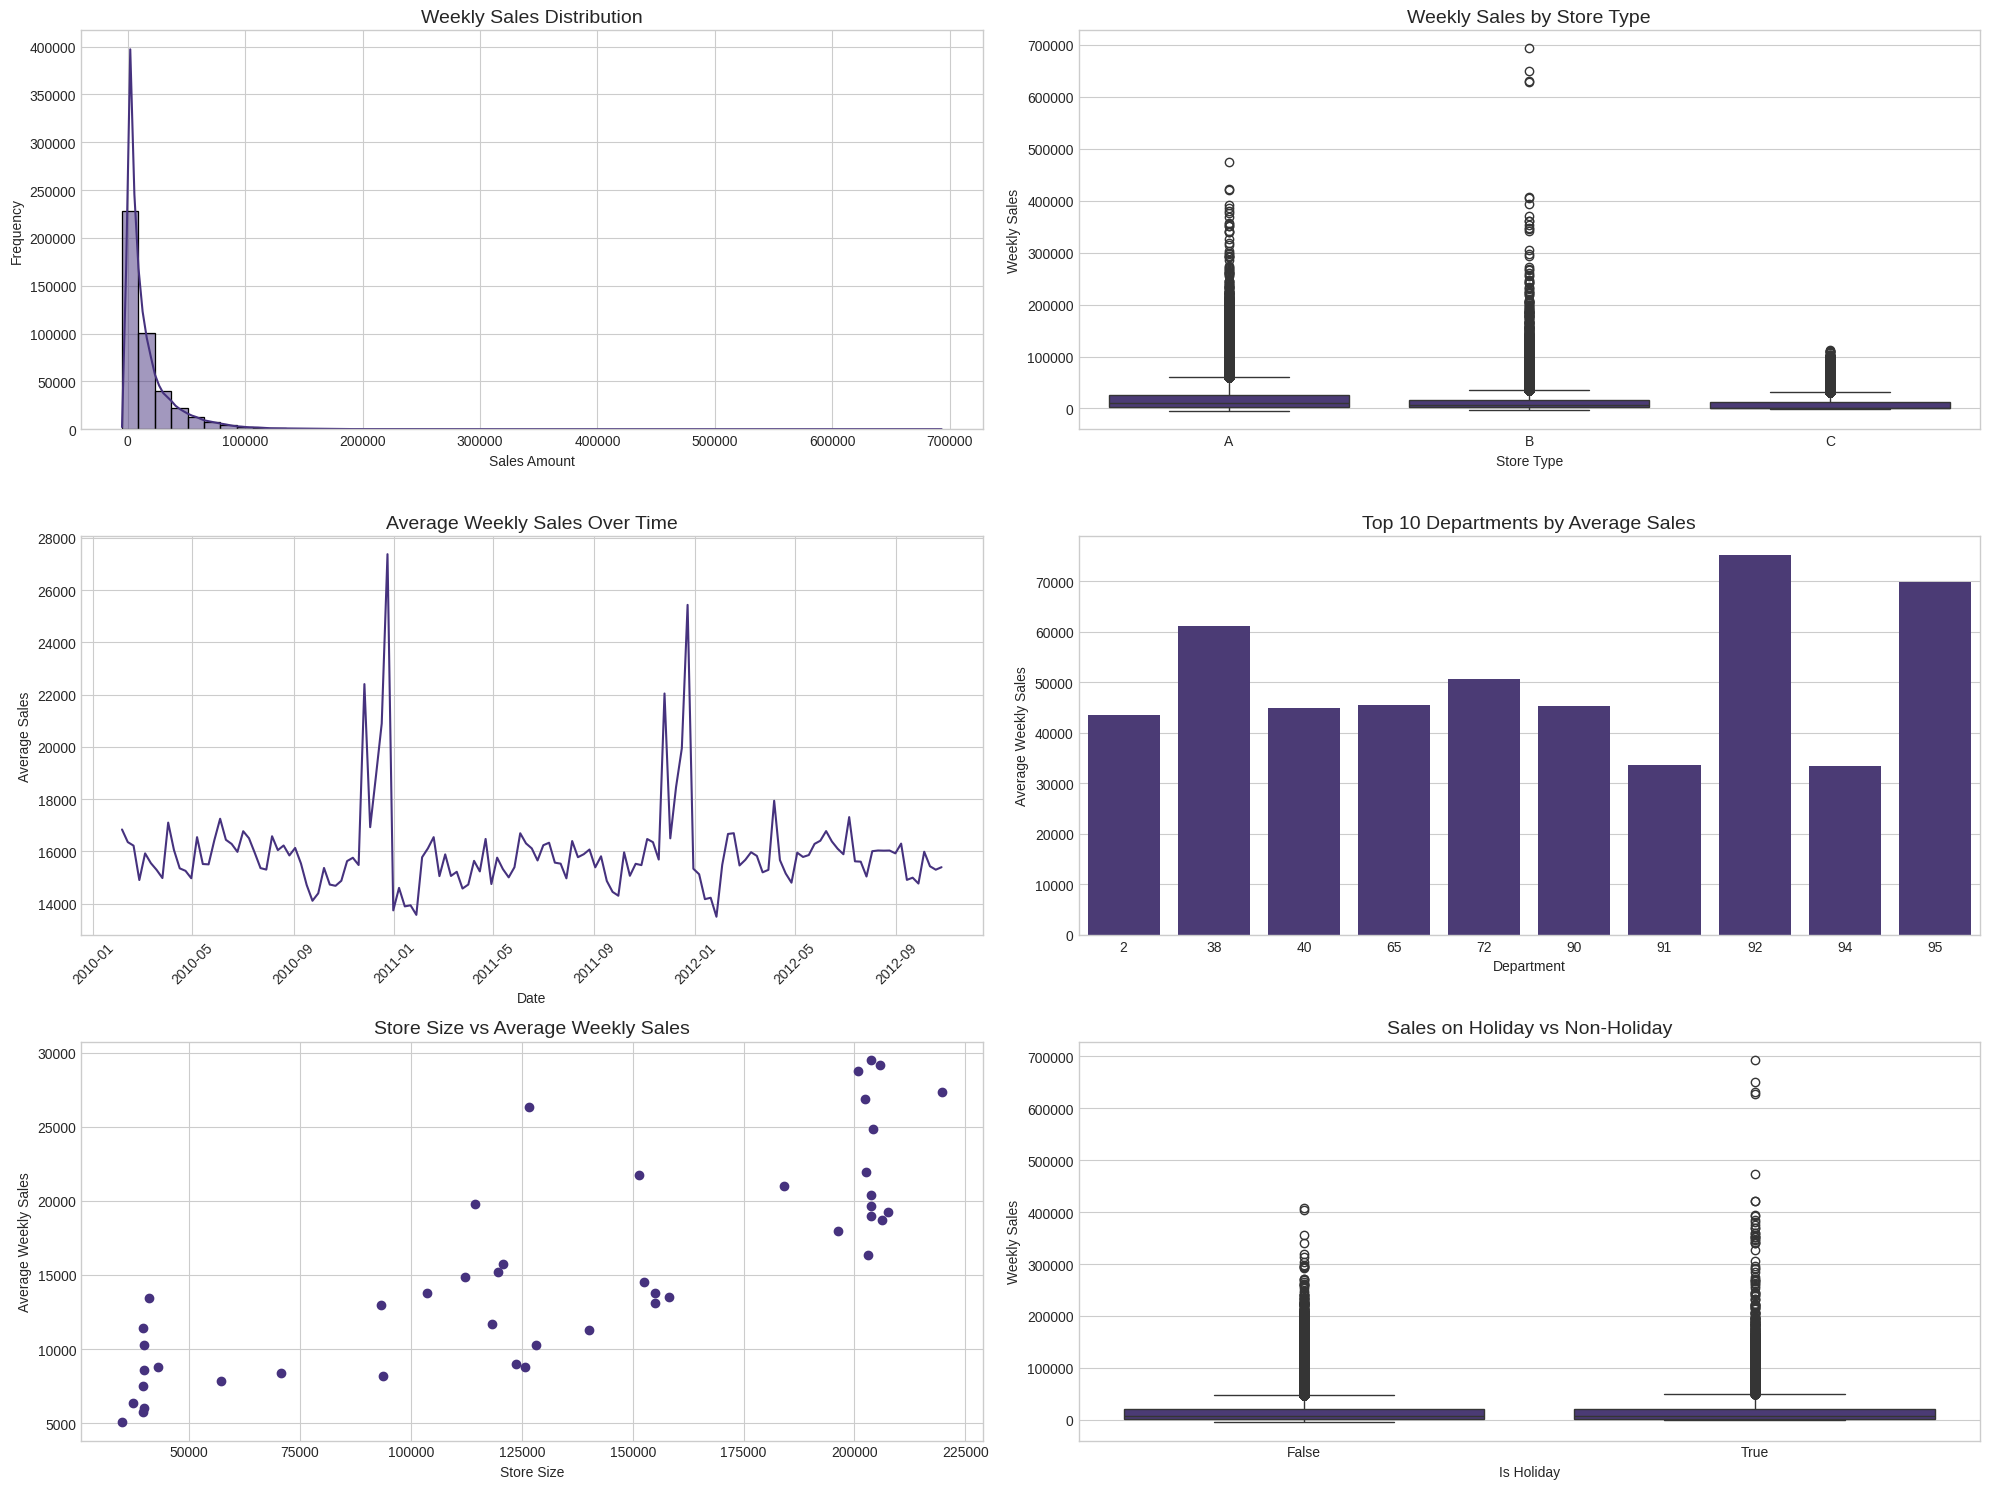

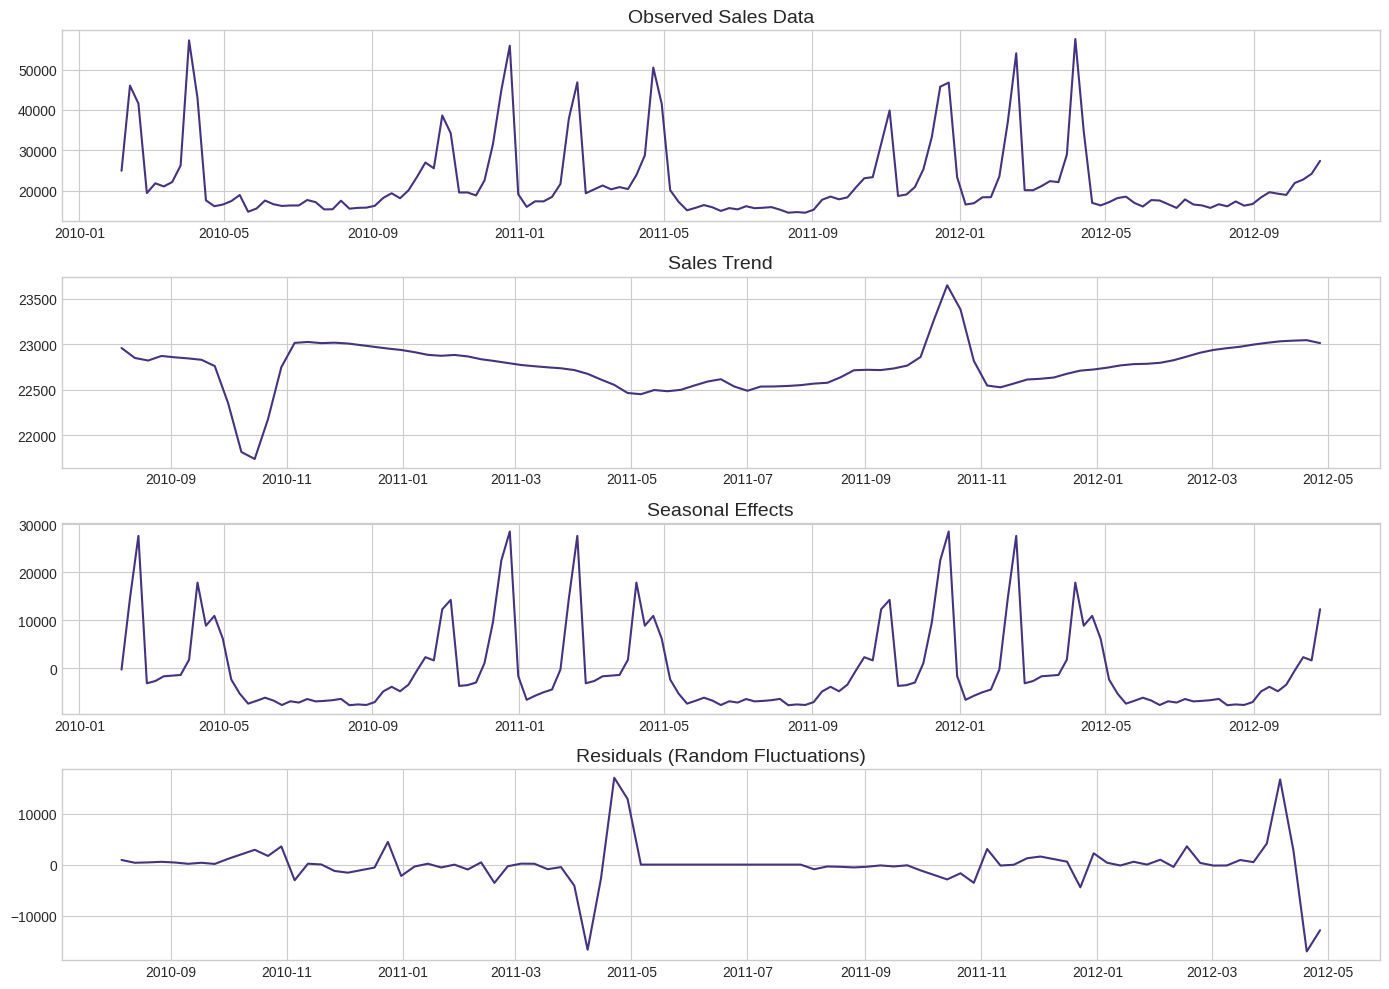

In [7]:
# Create a figure for displaying multiple plots
plt.figure(figsize=(20, 15))

# 1. Sales distribution
plt.subplot(3, 2, 1)
sns.histplot(train_df['Weekly_Sales'], bins=50, kde=True)
plt.title('Weekly Sales Distribution', fontsize=14)
plt.xlabel('Sales Amount')
plt.ylabel('Frequency')

# 2. Sales by store type
plt.subplot(3, 2, 2)
merged_data = pd.merge(train_df, stores_df, on='Store')
sns.boxplot(x='Type', y='Weekly_Sales', data=merged_data)
plt.title('Weekly Sales by Store Type', fontsize=14)
plt.xlabel('Store Type')
plt.ylabel('Weekly Sales')

# 3. Sales trend over time
plt.subplot(3, 2, 3)
# Aggregate sales by date for clearer visualization
sales_by_date = train_df.groupby('Date')['Weekly_Sales'].mean().reset_index()
plt.plot(sales_by_date['Date'], sales_by_date['Weekly_Sales'])
plt.title('Average Weekly Sales Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)

# 4. Sales by department (top 10 departments)
plt.subplot(3, 2, 4)
dept_sales = train_df.groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=dept_sales.index, y=dept_sales.values)
plt.title('Top 10 Departments by Average Sales', fontsize=14)
plt.xlabel('Department')
plt.ylabel('Average Weekly Sales')

# 5. Store size vs sales
plt.subplot(3, 2, 5)
store_size_sales = pd.merge(train_df, stores_df, on='Store')
store_size_sales = store_size_sales.groupby('Store')[['Size', 'Weekly_Sales']].mean().reset_index()
plt.scatter(store_size_sales['Size'], store_size_sales['Weekly_Sales'])
plt.title('Store Size vs Average Weekly Sales', fontsize=14)
plt.xlabel('Store Size')
plt.ylabel('Average Weekly Sales')

# 6. Holiday vs non-holiday sales
plt.subplot(3, 2, 6)
sns.boxplot(x='IsHoliday', y='Weekly_Sales', data=train_df)
plt.title('Sales on Holiday vs Non-Holiday', fontsize=14)
plt.xlabel('Is Holiday')
plt.ylabel('Weekly Sales')

plt.tight_layout()
plt.savefig('sales_analysis.png', dpi=300)
plt.show()

# Seasonal decomposition to analyze seasonal patterns
# Let's take a single store-department combination for clarity
store1_dept1 = train_df[(train_df['Store'] == 1) & (train_df['Dept'] == 1)]
store1_dept1 = store1_dept1.set_index('Date')
store1_dept1 = store1_dept1.sort_index()

# Check if we have enough data points for decomposition
if len(store1_dept1) >= 52:  # At least a year of weekly data
    decomposition = seasonal_decompose(store1_dept1['Weekly_Sales'], model='additive', period=52)

    plt.figure(figsize=(14, 10))
    plt.subplot(4, 1, 1)
    plt.plot(decomposition.observed)
    plt.title('Observed Sales Data', fontsize=14)

    plt.subplot(4, 1, 2)
    plt.plot(decomposition.trend)
    plt.title('Sales Trend', fontsize=14)

    plt.subplot(4, 1, 3)
    plt.plot(decomposition.seasonal)
    plt.title('Seasonal Effects', fontsize=14)

    plt.subplot(4, 1, 4)
    plt.plot(decomposition.resid)
    plt.title('Residuals (Random Fluctuations)', fontsize=14)

    plt.tight_layout()
    plt.savefig('seasonal_decomposition.png', dpi=300)
    plt.show()
else:
    print("Not enough data points for seasonal decomposition")

# **Enhanced Data Preprocessing**


No missing values in Train

No missing values in Test

Missing Values in Features:
              Missing Values  Percentage
MarkDown2               5269   64.334554
MarkDown4               4726   57.704518
MarkDown3               4577   55.885226
MarkDown1               4158   50.769231
MarkDown5               4140   50.549451
CPI                      585    7.142857
Unemployment             585    7.142857


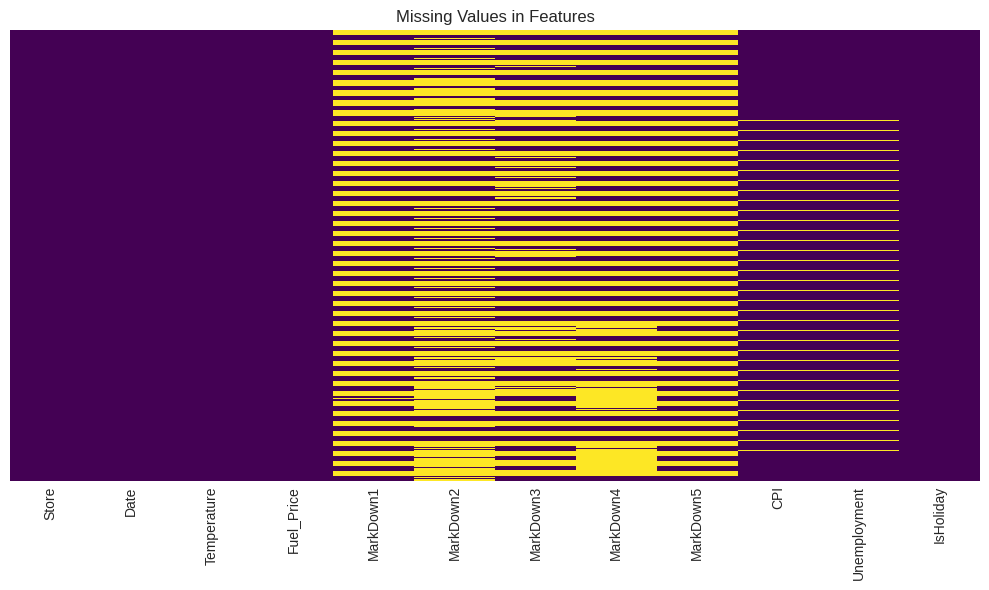


No missing values in Stores


In [8]:
# Function to check and visualize missing values
def visualize_missing_values(dataframes_dict):
    for name, df in dataframes_dict.items():
        missing = df.isnull().sum()
        missing_percent = (missing / len(df)) * 100

        # Only show columns with missing values
        missing_data = pd.DataFrame({
            'Missing Values': missing,
            'Percentage': missing_percent
        }).sort_values('Percentage', ascending=False)

        missing_data = missing_data[missing_data['Missing Values'] > 0]

        if not missing_data.empty:
            print(f"\nMissing Values in {name}:")
            print(missing_data)

            # Visualize missing values
            plt.figure(figsize=(10, 6))
            sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
            plt.title(f'Missing Values in {name}')
            plt.tight_layout()
            plt.show()
        else:
            print(f"\nNo missing values in {name}")

# Check missing values in all datasets
dataframes = {
    'Train': train_df,
    'Test': test_df,
    'Features': features_df,
    'Stores': stores_df
}

visualize_missing_values(dataframes)

# **Enhanced Data Preprocessing**

In [10]:
# Create a comprehensive dataset by merging all data sources
def preprocess_and_merge_data():
    # First, handle missing values in features_df

    # Fill MarkDown columns with zeros (no promotion)
    markdown_cols = [col for col in features_df.columns if 'MarkDown' in col]
    features_df[markdown_cols] = features_df[markdown_cols].fillna(0)

    # For CPI and Unemployment, we'll use a more sophisticated approach
    # Instead of dropping rows, we'll impute based on store and date patterns

    # Group by store and sort by date to forward fill values
    # This assumes that these economic indicators change slowly over time
    features_filled = features_df.copy()
    # Sort by Store and Date
    features_filled = features_filled.sort_values(['Store', 'Date'])
    # Forward fill within each store group
    features_filled['CPI'] = features_filled.groupby('Store')['CPI'].transform(
        lambda x: x.fillna(method='ffill').fillna(method='bfill')
    )
    features_filled['Unemployment'] = features_filled.groupby('Store')['Unemployment'].transform(
        lambda x: x.fillna(method='ffill').fillna(method='bfill')
    )

    # Create date-based features
    features_filled['Year'] = features_filled['Date'].dt.year
    features_filled['Month'] = features_filled['Date'].dt.month
    features_filled['Day'] = features_filled['Date'].dt.day
    features_filled['Week'] = features_filled['Date'].dt.isocalendar().week
    features_filled['DayOfWeek'] = features_filled['Date'].dt.dayofweek
    features_filled['Quarter'] = features_filled['Date'].dt.quarter

    # Create cyclical features for Month and DayOfWeek to capture periodicity
    features_filled['Month_sin'] = np.sin(2 * np.pi * features_filled['Month']/12)
    features_filled['Month_cos'] = np.cos(2 * np.pi * features_filled['Month']/12)
    features_filled['DayOfWeek_sin'] = np.sin(2 * np.pi * features_filled['DayOfWeek']/7)
    features_filled['DayOfWeek_cos'] = np.cos(2 * np.pi * features_filled['DayOfWeek']/7)

    # Create special event indicators
    # Super Bowl: beginning of February
    features_filled['SuperBowl'] = ((features_filled['Month'] == 2) & (features_filled['Day'] <= 7)).astype(int)
    # Labor Day: first Monday in September
    features_filled['LaborDay'] = ((features_filled['Month'] == 9) & (features_filled['Day'] <= 7) &
                                 (features_filled['DayOfWeek'] == 0)).astype(int)
    # Thanksgiving: 4th Thursday in November
    features_filled['Thanksgiving'] = ((features_filled['Month'] == 11) & (features_filled['Day'] >= 22) &
                                     (features_filled['Day'] <= 28) & (features_filled['DayOfWeek'] == 3)).astype(int)
    # Christmas: December 25
    features_filled['Christmas'] = ((features_filled['Month'] == 12) & (features_filled['Day'] == 25)).astype(int)

    # Create pre-holiday indicators (1 week before)
    features_filled['PreHoliday'] = features_filled['IsHoliday'].shift(-1, fill_value=False).astype(int)

    # Merge with stores data to get store type and size
    features_merged = pd.merge(features_filled, stores_df, on='Store', how='left')

    # Create store type dummy variables
    features_merged = pd.get_dummies(features_merged, columns=['Type'], prefix='StoreType')

    # Normalize store size to make it comparable across different store types
    features_merged['Size_Normalized'] = features_merged.groupby('Store')['Size'].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0
    )

    # Merge with training data
    train_merged = pd.merge(train_df, features_merged, on=['Store', 'Date', 'IsHoliday'], how='left')

    # For test data
    test_merged = pd.merge(test_df, features_merged, on=['Store', 'Date', 'IsHoliday'], how='left')

    return train_merged, test_merged

# Apply preprocessing and merging
train_processed, test_processed = preprocess_and_merge_data()

print("Processed train shape:", train_processed.shape)
print("Processed test shape:", test_processed.shape)

# Check for missing values after processing
missing_train = train_processed.isnull().sum()
print("Missing values in training data after processing:")
print(missing_train[missing_train > 0])

missing_test = test_processed.isnull().sum()
print("Missing values in test data after processing:")
print(missing_test[missing_test > 0])

Processed train shape: (421570, 34)
Processed test shape: (115064, 33)
Missing values in training data after processing:
Series([], dtype: int64)
Missing values in test data after processing:
Series([], dtype: int64)


# **Creating Lag Features and Additional Features**

In [11]:
# Add lag features - previous weeks' sales are strong predictors
def add_lag_features(train_df, test_df):
    # Combine train and test for consistent lag creation
    train_df['is_train'] = 1
    test_df['is_train'] = 0
    test_df['Weekly_Sales'] = np.nan  # Placeholder for test set

    combined = pd.concat([train_df, test_df], ignore_index=True, sort=False)
    combined = combined.sort_values(['Store', 'Dept', 'Date'])

    # Create lag features for each store-department combination
    for lag in [1, 2, 4, 8, 12, 26, 52]:  # 1 week, 2 weeks, 1 month, 2 months, 3 months, 6 months, 1 year
        combined[f'Sales_Lag_{lag}'] = combined.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)

    # Create rolling window features (mean, std)
    for window in [4, 8, 12, 26]:
        combined[f'Sales_Roll_Mean_{window}'] = combined.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        combined[f'Sales_Roll_Std_{window}'] = combined.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )

    # Add trend features
    combined['Trend'] = combined.groupby(['Store', 'Dept']).cumcount() + 1

    # Split back to train and test
    train_df_with_lags = combined[combined['is_train'] == 1].copy()
    test_df_with_lags = combined[combined['is_train'] == 0].copy()

    # Drop is_train column
    train_df_with_lags.drop('is_train', axis=1, inplace=True)
    test_df_with_lags.drop(['is_train', 'Weekly_Sales'], axis=1, inplace=True)

    return train_df_with_lags, test_df_with_lags

# Apply lag feature creation
train_final, test_final = add_lag_features(train_processed, test_processed)

print("Train shape after adding lag features:", train_final.shape)
print("Test shape after adding lag features:", test_final.shape)

# Handle any remaining missing values in lag features
# Fill with median for each store-department combination
for col in train_final.columns:
    if train_final[col].isnull().sum() > 0 and 'Sales_Lag' in col or 'Sales_Roll' in col:
        train_final[col] = train_final.groupby(['Store', 'Dept'])[col].transform(
            lambda x: x.fillna(x.median()) if not x.median() != x.median() else 0
        )

for col in test_final.columns:
    if test_final[col].isnull().sum() > 0 and 'Sales_Lag' in col or 'Sales_Roll' in col:
        test_final[col] = test_final.groupby(['Store', 'Dept'])[col].transform(
            lambda x: x.fillna(x.median()) if not x.median() != x.median() else 0
        )

# Check remaining missing values
missing_train = train_final.isnull().sum()
print("Missing values after lag feature creation (train):")
print(missing_train[missing_train > 0])

missing_test = test_final.isnull().sum()
print("Missing values after lag feature creation (test):")
print(missing_test[missing_test > 0])

# Fill any remaining missing values with median
for col in train_final.columns:
    if train_final[col].isnull().sum() > 0:
        train_final[col] = train_final[col].fillna(train_final[col].median())

for col in test_final.columns:
    if test_final[col].isnull().sum() > 0:
        test_final[col] = test_final[col].fillna(train_final[col].median() if col in train_final.columns else 0)

Train shape after adding lag features: (421570, 50)
Test shape after adding lag features: (115064, 49)
Missing values after lag feature creation (train):
Series([], dtype: int64)
Missing values after lag feature creation (test):
Series([], dtype: int64)


In [15]:
# Already shared earlier — paste once in your notebook/script
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_outlier_bounds(series, method='iqr'):
    if method == 'iqr':
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
    elif method == 'zscore':
        mean = series.mean()
        std = series.std()
        lower = mean - 3 * std
        upper = mean + 3 * std
    else:
        raise ValueError("method must be 'iqr' or 'zscore'")
    return lower, upper

def detect_outliers(df, method='iqr'):
    outlier_report = []
    for col in df.select_dtypes(include=np.number).columns:
        lower, upper = get_outlier_bounds(df[col], method)
        outliers = df[(df[col] < lower) | (df[col] > upper)][col]
        outlier_report.append({
            'Feature': col,
            'Outliers Count': outliers.count(),
            'Outlier %': 100 * outliers.count() / df[col].shape[0]
        })
    return pd.DataFrame(outlier_report).sort_values(by='Outliers Count', ascending=False)

def plot_outliers(df, columns=None, method='iqr', n_cols=3, figsize=(15, 10)):
    numeric_cols = df.select_dtypes(include=np.number).columns
    columns = columns if columns else numeric_cols

    n_rows = int(np.ceil(len(columns) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(columns):
        lower, upper = get_outlier_bounds(df[col], method)
        sns.boxplot(x=df[col], ax=axes[i])
        axes[i].axvline(lower, color='red', linestyle='--', label='Lower Bound')
        axes[i].axvline(upper, color='green', linestyle='--', label='Upper Bound')
        axes[i].set_title(f'Boxplot: {col}')
        axes[i].legend()

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [16]:
# Run the outlier detection
outlier_report = detect_outliers(train_final, method='iqr')

# Print top 10 features with most outliers
print(outlier_report.head(10))


              Feature  Outliers Count  Outlier %
6           MarkDown2          103148  24.467585
7           MarkDown3           84674  20.085395
8           MarkDown4           79134  18.771260
5           MarkDown1           55789  13.233627
37   Sales_Roll_Std_4           43137  10.232464
39   Sales_Roll_Std_8           40498   9.606471
9           MarkDown5           40458   9.596983
41  Sales_Roll_Std_12           38395   9.107622
43  Sales_Roll_Std_26           37092   8.798539
35       Sales_Lag_52           35943   8.525986


Skewness of MarkDown2: 10.65


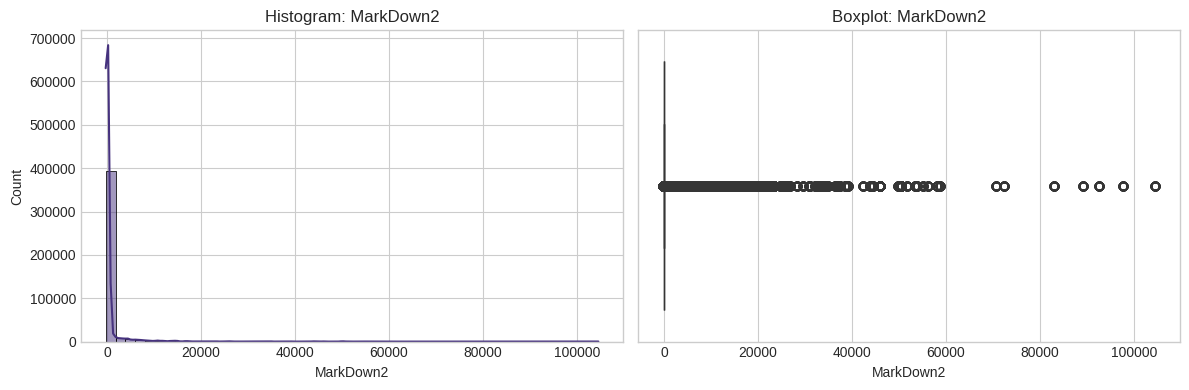

Skewness of MarkDown3: 14.92


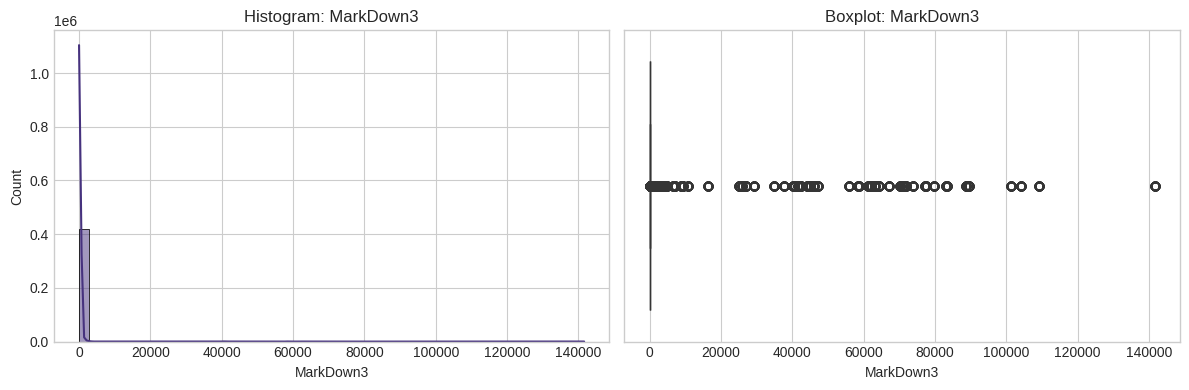

Skewness of MarkDown4: 8.08


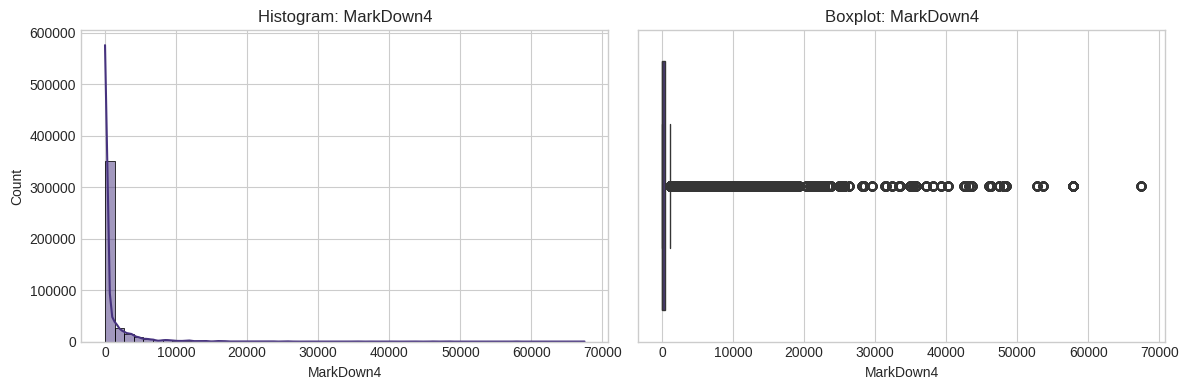

Skewness of MarkDown1: 4.73


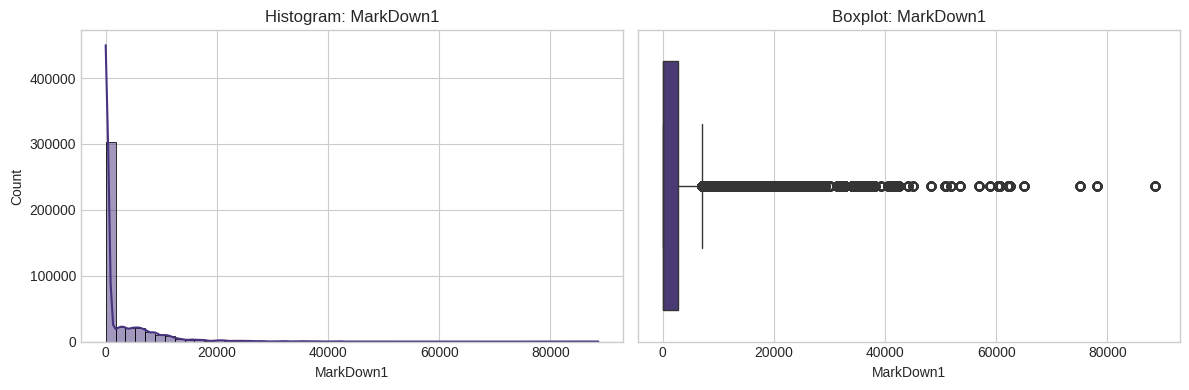

Skewness of Sales_Roll_Std_4: 16.52


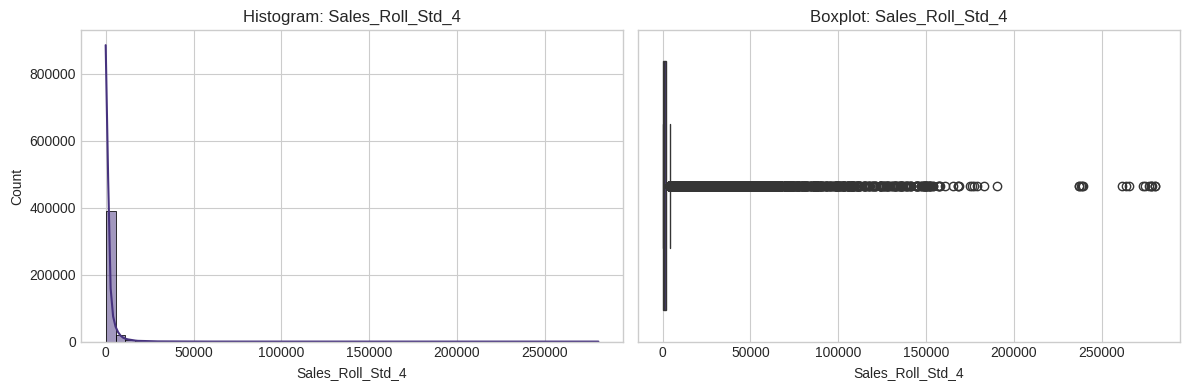

Skewness of Sales_Roll_Std_8: 11.61


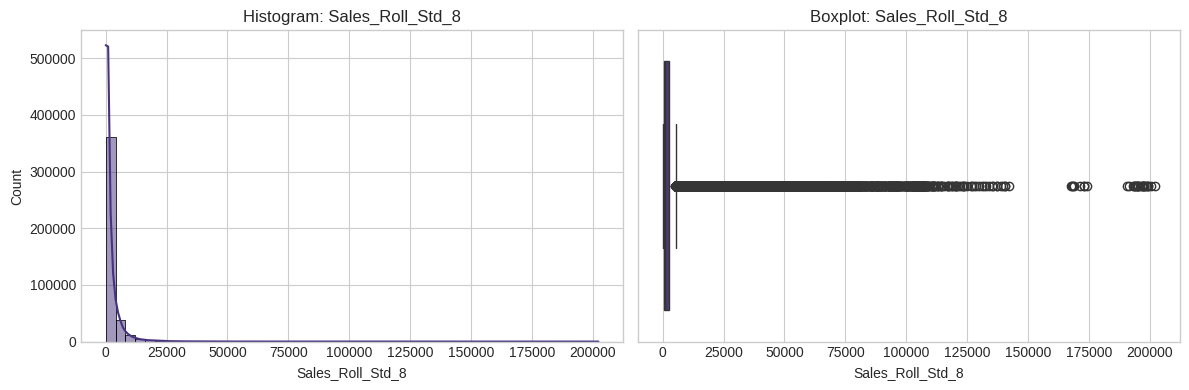

Skewness of MarkDown5: 9.96


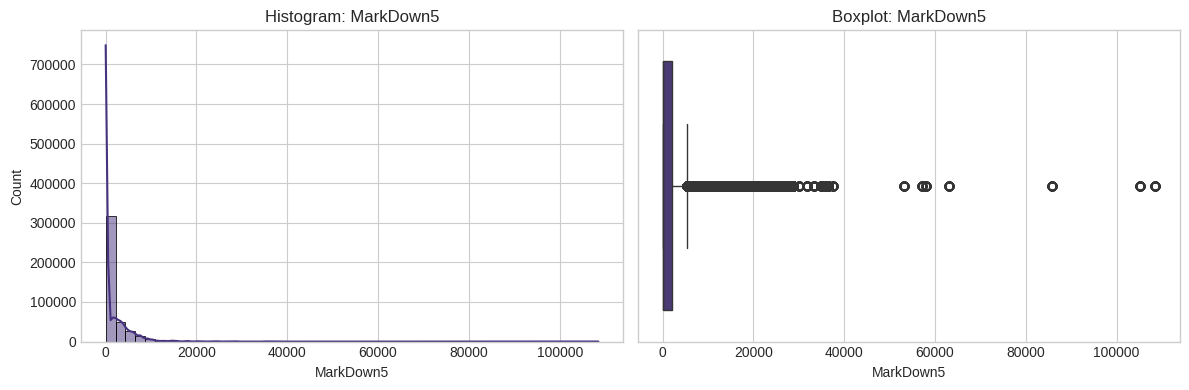

Skewness of Sales_Roll_Std_12: 9.66


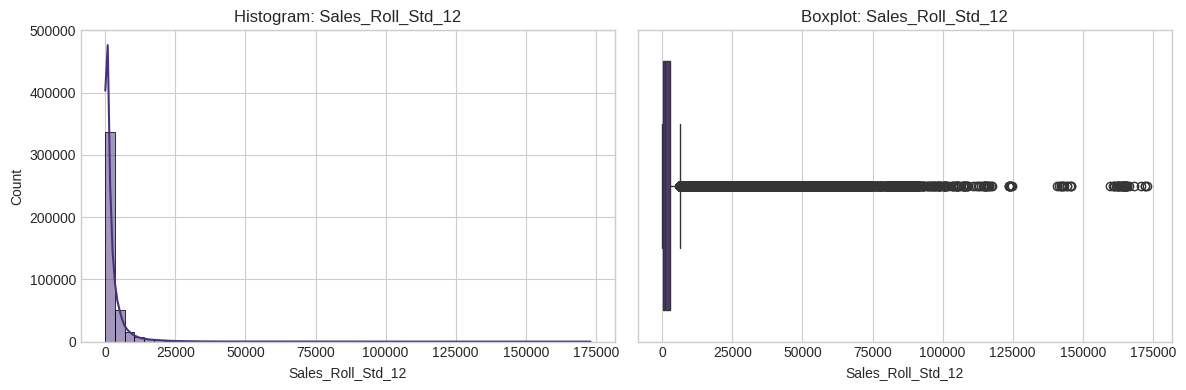

Skewness of Sales_Roll_Std_26: 6.57


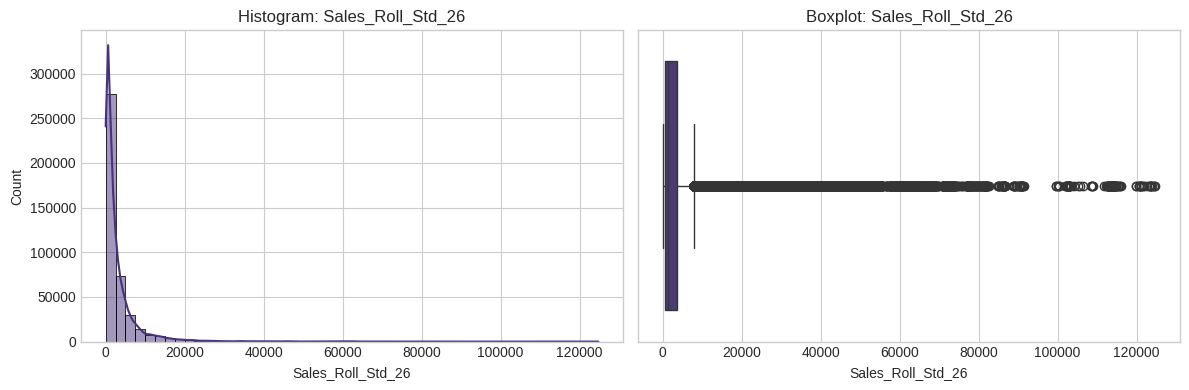

Skewness of Sales_Lag_52: 3.10


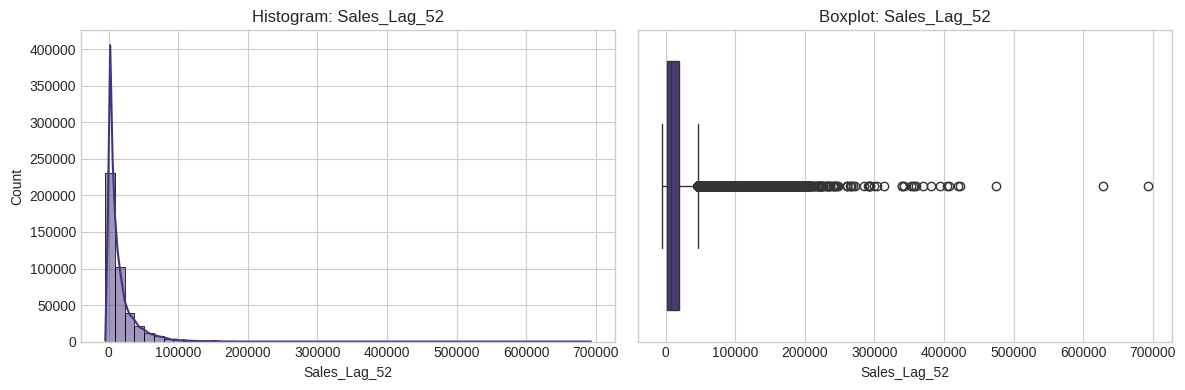

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

# Top outlier features from your result
top_outlier_features = [
    'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown1', 'Sales_Roll_Std_4',
    'Sales_Roll_Std_8', 'MarkDown5', 'Sales_Roll_Std_12', 'Sales_Roll_Std_26', 'Sales_Lag_52'
]

# Plot distributions and compute skewness
for col in top_outlier_features:
    plt.figure(figsize=(12, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(train_final[col].dropna(), bins=50, kde=True)
    plt.title(f"Histogram: {col}")

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train_final[col])
    plt.title(f"Boxplot: {col}")

    # Skewness
    col_skew = skew(train_final[col].dropna())
    print(f"Skewness of {col}: {col_skew:.2f}")

    plt.tight_layout()
    plt.show()


In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# ---------------- OUTLIER HANDLING FUNCTION ---------------- #
def apply_outlier_handling(train_df, test_df):
    # --- CAPPING ---
    for col in ['Sales_Roll_Std_4', 'Sales_Lag_52']:
        upper_lim = train_df[col].quantile(0.95)
        train_df[col] = np.where(train_df[col] > upper_lim, upper_lim, train_df[col])
        test_df[col] = np.where(test_df[col] > upper_lim, upper_lim, test_df[col])

    # --- LOG TRANSFORMATION ---
    for col in ['MarkDown2', 'MarkDown3']:
        train_df[col + '_log'] = np.log1p(train_df[col])
        test_df[col + '_log'] = np.log1p(test_df[col])

    return train_df, test_df

# ---------------- APPLY OUTLIER HANDLING ---------------- #
train_final, test_final = apply_outlier_handling(train_final, test_final)


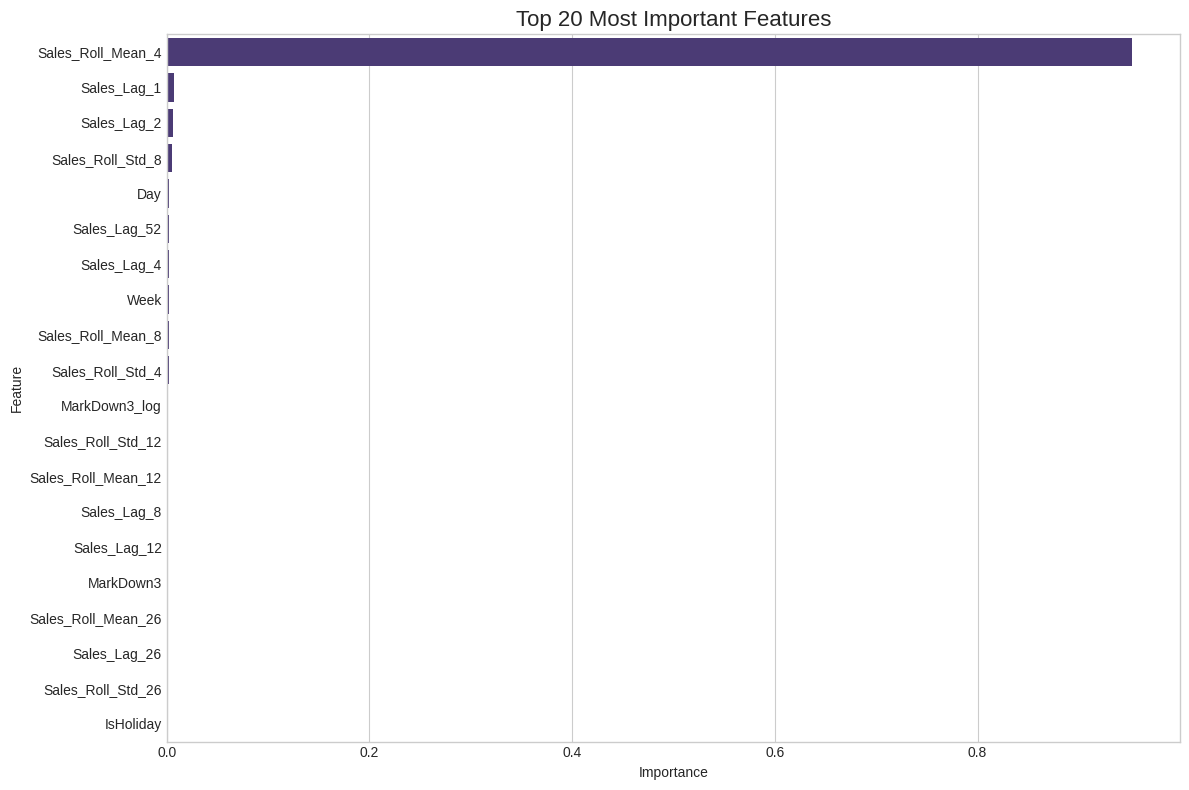

Selected 4 features for modeling


In [24]:
# ---------------- FEATURE SELECTION & MODEL PREP ---------------- #
# Drop target and date columns
X = train_final.drop(['Weekly_Sales', 'Date'], axis=1)
y = train_final['Weekly_Sales']

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute NaN values using the median
X = X.fillna(X.median())

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------- FEATURE IMPORTANCE ANALYSIS ---------------- #
forest = RandomForestRegressor(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': forest.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Visualize top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Top 20 Most Important Features', fontsize=16)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

# Select top features for modeling
top_features = feature_importances[feature_importances['Importance'] > 0.005]['Feature'].tolist()
print(f"Selected {len(top_features)} features for modeling")

# Reduce dataset to selected features
X_train_selected = X_train[top_features]
X_val_selected = X_val[top_features]



Linear Regression Performance:
Train RMSE: $4180.47
Validation RMSE: $4211.46
Train MAE: $1358.10
Validation MAE: $1383.84
Train R²: 0.9660
Validation R²: 0.9660


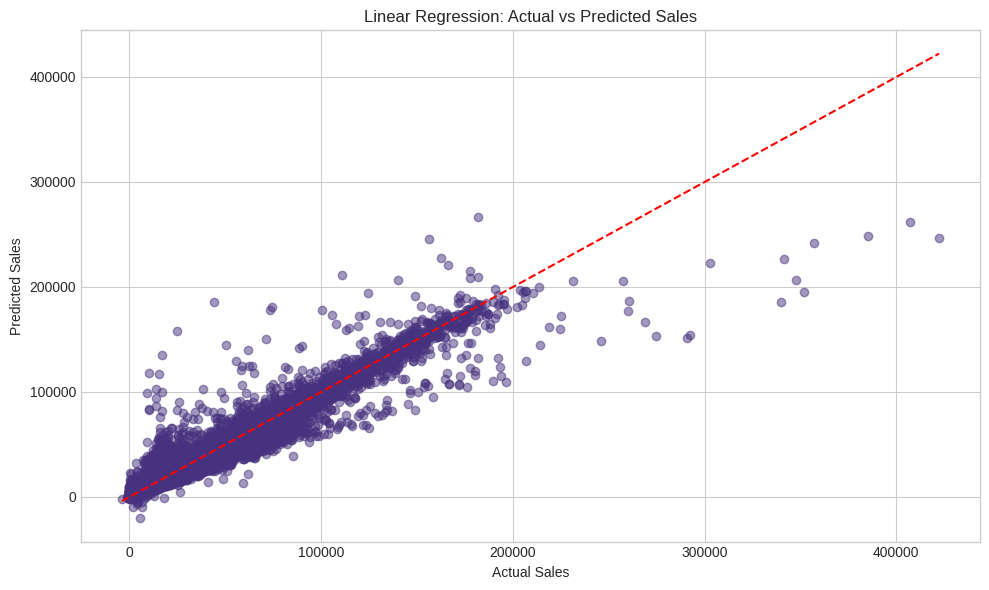


Random Forest Performance:
Train RMSE: $1423.00
Validation RMSE: $3848.86
Train MAE: $442.06
Validation MAE: $1210.59
Train R²: 0.9961
Validation R²: 0.9716


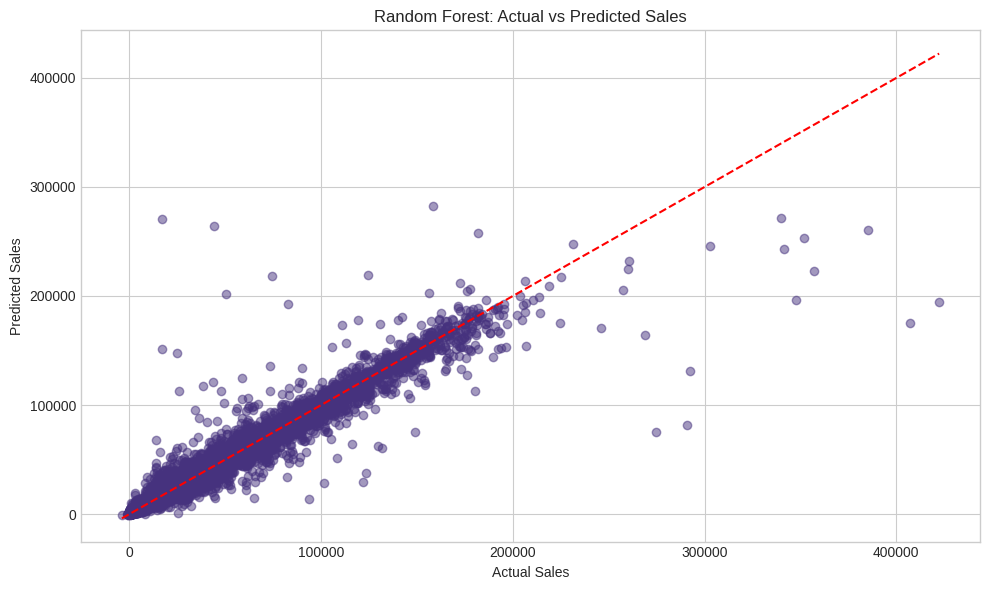


Gradient Boosting Performance:
Train RMSE: $3851.44
Validation RMSE: $4395.13
Train MAE: $1523.66
Validation MAE: $1569.50
Train R²: 0.9712
Validation R²: 0.9630


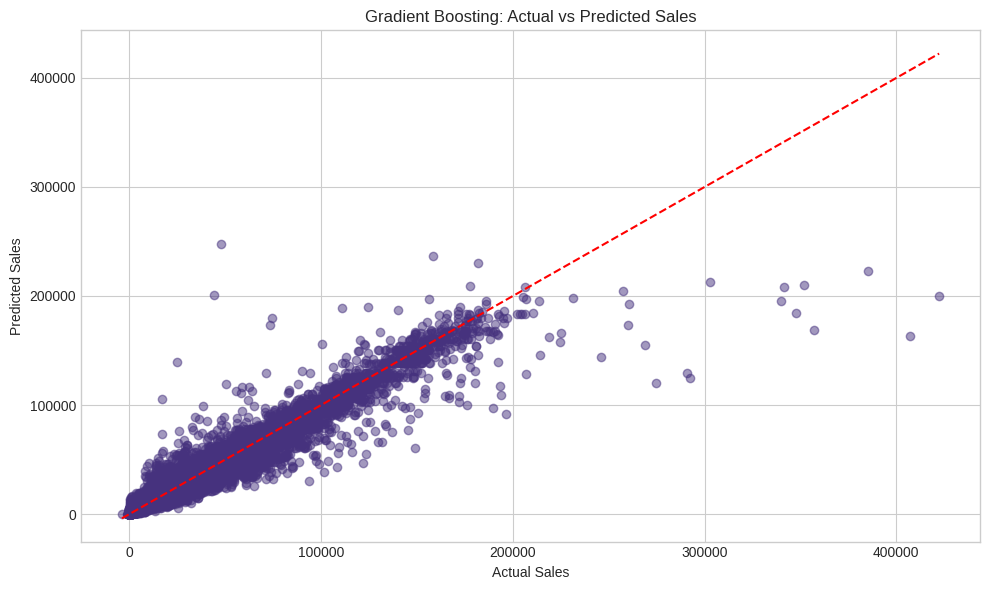


XGBoost Performance:
Train RMSE: $3314.39
Validation RMSE: $4293.97
Train MAE: $1198.37
Validation MAE: $1312.02
Train R²: 0.9786
Validation R²: 0.9646


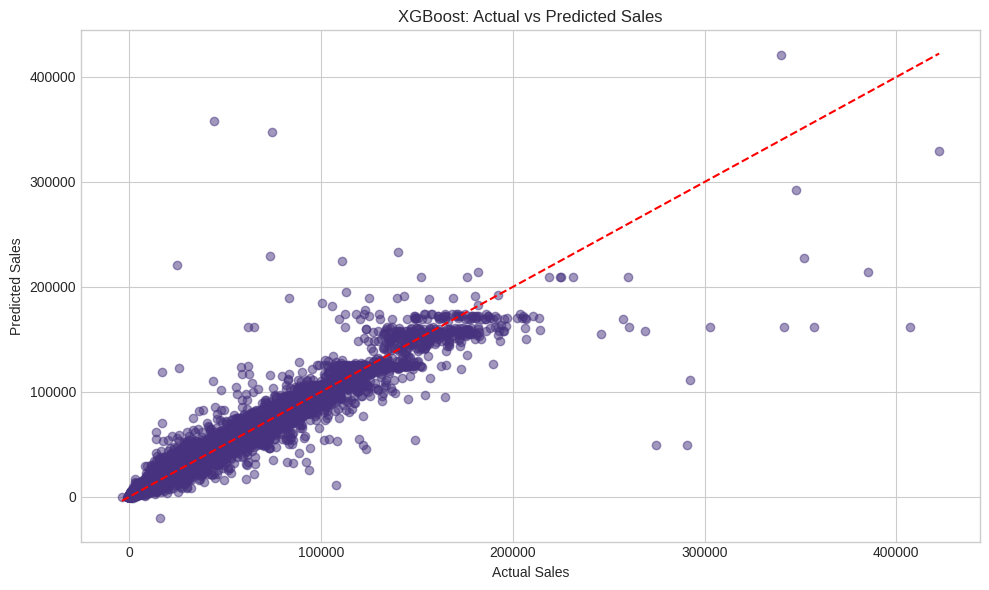

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 337256, number of used features: 4
[LightGBM] [Info] Start training from score 15979.221909

LightGBM Performance:
Train RMSE: $3850.40
Validation RMSE: $4271.62
Train MAE: $1347.16
Validation MAE: $1405.20
Train R²: 0.9712
Validation R²: 0.9650


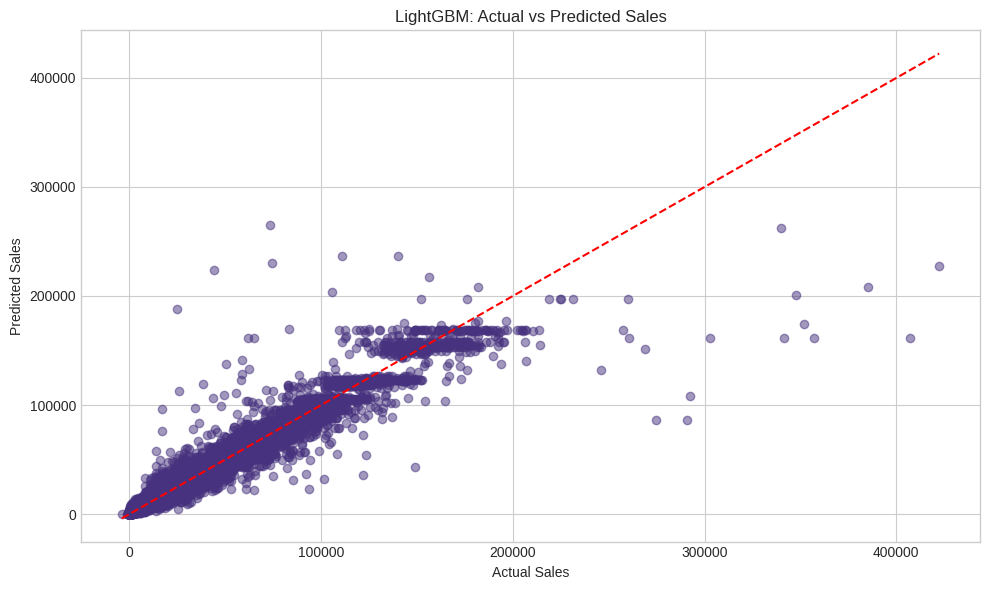


Model Comparison:
               Model   Train RMSE  Validation RMSE    Train MAE  \
1      Random Forest  1423.002122      3848.858927   442.057154   
0  Linear Regression  4180.465256      4211.455783  1358.095243   
4           LightGBM  3850.399465      4271.616531  1347.155927   
3            XGBoost  3314.386698      4293.974796  1198.371593   
2  Gradient Boosting  3851.437607      4395.129395  1523.660589   

   Validation MAE  Train R²  Validation R²  
1     1210.585395  0.996063       0.971592  
0     1383.838385  0.966024       0.965988  
4     1405.197225  0.971178       0.965009  
3     1312.021065  0.978644       0.964642  
2     1569.500449  0.971162       0.962956  


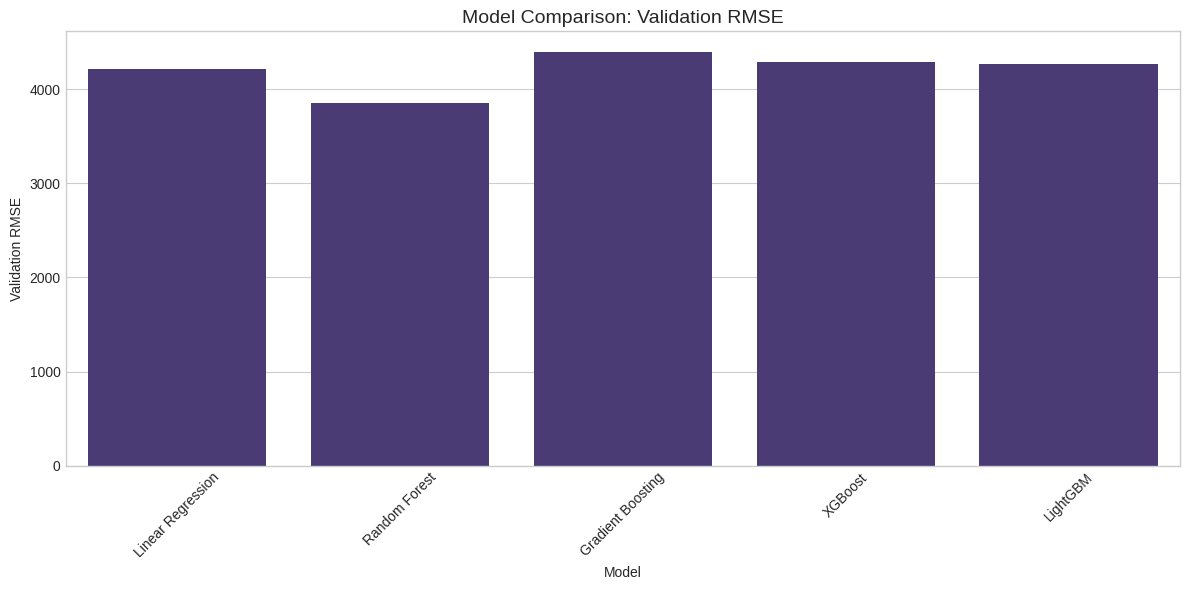

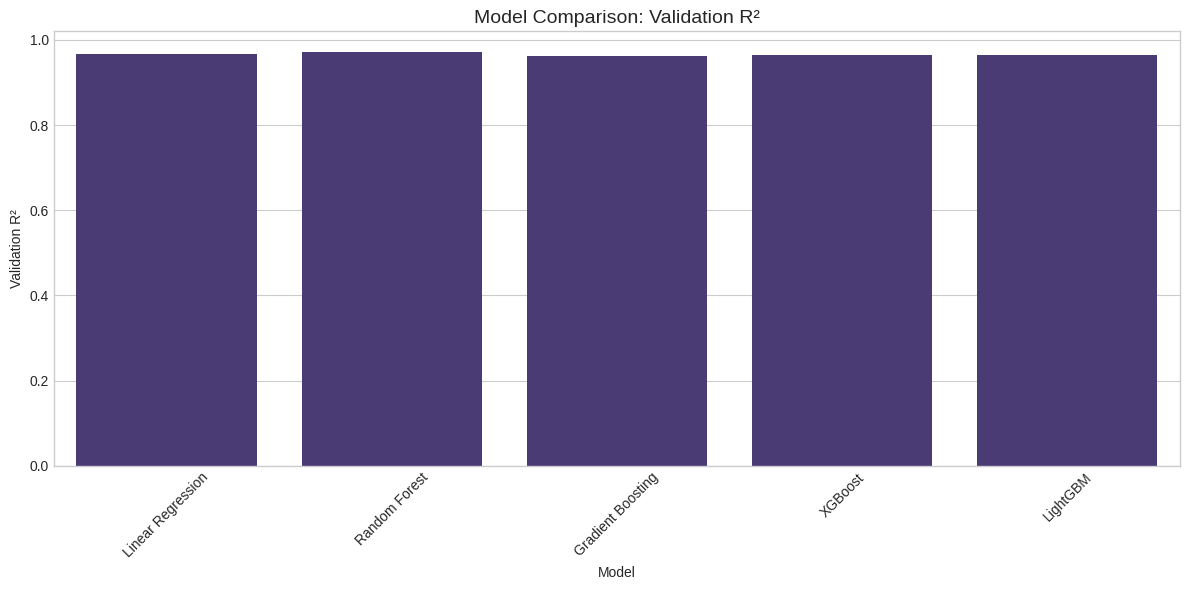

In [25]:
# ---------------- MODEL EVALUATION FUNCTION ---------------- #
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    train_mae = mean_absolute_error(y_train, train_preds)
    val_mae = mean_absolute_error(y_val, val_preds)
    train_r2 = r2_score(y_train, train_preds)
    val_r2 = r2_score(y_val, val_preds)

    print(f"\n{model_name} Performance:")
    print(f"Train RMSE: ${train_rmse:.2f}")
    print(f"Validation RMSE: ${val_rmse:.2f}")
    print(f"Train MAE: ${train_mae:.2f}")
    print(f"Validation MAE: ${val_mae:.2f}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Validation R²: {val_r2:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, val_preds, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel('Actual Sales')
    plt.ylabel('Predicted Sales')
    plt.title(f'{model_name}: Actual vs Predicted Sales')
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_predictions.png', dpi=300)
    plt.show()

    return {
        'model': model,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_r2': train_r2,
        'val_r2': val_r2
    }

# ---------------- TRAIN MULTIPLE MODELS ---------------- #
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train_selected, y_train, X_val_selected, y_val, name)

# ---------------- MODEL COMPARISON ---------------- #
comparison_df = pd.DataFrame({
    'Model': results.keys(),
    'Train RMSE': [res['train_rmse'] for res in results.values()],
    'Validation RMSE': [res['val_rmse'] for res in results.values()],
    'Train MAE': [res['train_mae'] for res in results.values()],
    'Validation MAE': [res['val_mae'] for res in results.values()],
    'Train R²': [res['train_r2'] for res in results.values()],
    'Validation R²': [res['val_r2'] for res in results.values()],
})

print("\nModel Comparison:")
print(comparison_df.sort_values('Validation RMSE'))

# Visualizations
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Validation RMSE', data=comparison_df)
plt.title('Model Comparison: Validation RMSE', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_comparison_rmse.png', dpi=300)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Validation R²', data=comparison_df)
plt.title('Model Comparison: Validation R²', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_comparison_r2.png', dpi=300)
plt.show()


In [29]:
import os
import joblib
import json # Import the json module

# Find the best model based on the lowest validation RMSE
best_model_name = comparison_df.sort_values('Validation RMSE').iloc[0]['Model']
best_model = results[best_model_name]['model']

# Create the 'model' directory if it doesn't exist
os.makedirs('model', exist_ok=True)

# Save the best model
joblib.dump(best_model, f'model/{best_model_name.lower().replace(" ", "_")}_best_model.joblib')

# Save the model performance metrics as JSON
model_info = {
    'best_model': {
        'model_name': best_model_name,
        'validation_rmse': results[best_model_name]['val_rmse'],
        'validation_mae': results[best_model_name]['val_mae'],
        'validation_r2': results[best_model_name]['val_r2'],
        'train_rmse': results[best_model_name]['train_rmse'],
        'train_mae': results[best_model_name]['train_mae'],
        'train_r2': results[best_model_name]['train_r2'],
        'training_date': datetime.now().strftime('%Y-%m-%d')
    }
}

# Save metadata as a JSON file for future reference
with open('model/best_model_info.json', 'w') as f:
    json.dump(model_info, f)

print(f"Best model '{best_model_name}' saved successfully!")

Best model 'Random Forest' saved successfully!


In [30]:
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming models_comparison dataframe already exists
best_model_name = comparison_df.sort_values('Validation RMSE').iloc[0]['Model']
print(f"Tuning hyperparameters for {best_model_name}")

# Define the parameter grid and model depending on the best model
if best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    model = xgb.XGBRegressor(random_state=42)

elif best_model_name == 'LightGBM':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 63, 127],
        'subsample': [0.8, 0.9, 1.0]
    }
    model = lgb.LGBMRegressor(random_state=42)

elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    model = RandomForestRegressor(random_state=42)

elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0]
    }
    model = GradientBoostingRegressor(random_state=42)

else:
    model = LinearRegression()
    param_grid = {}

# Perform randomized search if there are parameters to tune
if param_grid:
    # Use a smaller parameter grid for demonstration (can be expanded)
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,  # Number of random combinations to try (adjustable)
        cv=3,  # Number of cross-validation folds
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    # Initialize tqdm progress bar
    with tqdm(total=10) as pbar:  # Total iterations = n_iter
        # Fit the model using RandomizedSearchCV with a progress bar
        random_search.fit(X_train_selected, y_train)
        pbar.update(10)
        print("Best parameters:", random_search.best_params_)
        print("Best RMSE:", -random_search.best_score_)

    # Use best model from RandomizedSearchCV
    best_model = random_search.best_estimator_
else:
    best_model = model
    best_model.fit(X_train_selected, y_train)

# Final evaluation on validation set
final_preds = best_model.predict(X_val_selected)
final_rmse = np.sqrt(mean_squared_error(y_val, final_preds))
final_mae = mean_absolute_error(y_val, final_preds)  # Corrected here
final_r2 = r2_score(y_val, final_preds)

print("\nFinal Model Performance:")
print(f"RMSE: ${final_rmse:.2f}")
print(f"MAE: ${final_mae:.2f}")
print(f"R²: {final_r2:.4f}")

# Error distribution analysis
errors = y_val - final_preds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(errors, kde=True)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_val, y=errors)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Errors vs Actual Values')
plt.xlabel('Actual Sales')
plt.ylabel('Error')

plt.tight_layout()
plt.savefig('error_analysis.png', dpi=300)
plt.show()

# Store-Department Level Analysis
errors_by_store_dept = pd.DataFrame({
    'Store': X_val['Store'],
    'Dept': X_val['Dept'],
    'Actual': y_val,
    'Predicted': final_preds,
    'Error': errors,
    'AbsError': np.abs(errors)
})

# Average error by store
store_errors = errors_by_store_dept.groupby('Store')['AbsError'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 6))
store_errors.head(20).plot(kind='bar')
plt.title('Average Absolute Error by Store (Top 20)', fontsize=14)
plt.xlabel('Store')
plt.ylabel('Mean Absolute Error')
plt.tight_layout()
plt.savefig('store_errors.png', dpi=300)
plt.show()

# Average error by department
dept_errors = errors_by_store_dept.groupby('Dept')['AbsError'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 6))
dept_errors.head(20).plot(kind='bar')
plt.title('Average Absolute Error by Department (Top 20)', fontsize=14)
plt.xlabel('Department')
plt.ylabel('Mean Absolute Error')
plt.tight_layout()
plt.savefig('dept_errors.png', dpi=300)
plt.show()

Tuning hyperparameters for Random Forest


  0%|          | 0/10 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


  0%|          | 0/10 [06:23<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import joblib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from sklearn.model_selection import cross_val_predict

# Prepare the test data with the same features used in training
test_final_selected = test_final[top_features]

# Make predictions
test_predictions = best_model.predict(test_final_selected)

# Create submission dataframe
submission = pd.DataFrame({
    'Store': test_df['Store'],
    'Dept': test_df['Dept'],
    'Date': test_df['Date'],
    'Weekly_Sales': test_predictions
})

# Ensure no negative sales
submission['Weekly_Sales'] = submission['Weekly_Sales'].clip(lower=0)

# Save submission
submission.to_csv('walmart_sales_predictions.csv', index=False)
print("Predictions generated and saved to walmart_sales_predictions.csv")


In [ ]:
import os
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime

# Ensure the directory exists for saving model artifacts
os.makedirs('model', exist_ok=True)

# Save the best model
joblib.dump(best_model, 'model/walmart_sales_model.joblib')

# Save the feature list (important for preprocessing new data)
pd.Series(top_features).to_csv('model/model_features.csv', index=False)

# Save a sample of test data for reference
test_final_selected.head(5).to_csv('model/sample_input.csv', index=False)

# Optional: Save scaler if used for normalization or standardization
# joblib.dump(scaler, 'model/scaler.joblib')

# Save model metadata
model_info = {
    'model_type': best_model_name,
    'rmse': final_rmse,
    'mae': final_mae,
    'r2': final_r2,
    'feature_count': len(top_features),
    'training_date': datetime.now().strftime('%Y-%m-%d')
}

# Save metadata as a JSON file for future reference
with open('model/model_info.json', 'w') as f:
    json.dump(model_info, f)

# Optional: Create and save a summary visualization for model performance
plt.figure(figsize=(15, 10))
# Example plot - you can customize this to match your performance metrics
plt.plot(range(len(final_rmse)), final_rmse, label='RMSE')
plt.plot(range(len(final_mae)), final_mae, label='MAE')
plt.legend()
plt.title('Model Performance Metrics')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.savefig('model/model_performance.png')
plt.close()


In [ ]:
# Create summary visualization for model performance
plt.figure(figsize=(15, 10))

# 1. Model Performance Comparison (RMSE)
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Validation RMSE', data=models_comparison.sort_values('Validation RMSE'))
plt.title('Model Performance Comparison (RMSE)', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('RMSE ($)')

# 2. Feature Importance
plt.subplot(2, 2, 2)
top_10_features = feature_importances.head(10)
sns.barplot(x='Importance', y='Feature', data=top_10_features)
plt.title('Top 10 Important Features', fontsize=12)

# 3. Error Distribution
plt.subplot(2, 2, 3)
sns.histplot(errors, kde=True, bins=50)
plt.title('Prediction Error Distribution', fontsize=12)
plt.xlabel('Error ($)')

# 4. Sales Trend (Average Weekly Sales over Time)
plt.subplot(2, 2, 4)
sales_trend = train_df.groupby('Date')['Weekly_Sales'].mean().reset_index()
plt.plot(sales_trend['Date'], sales_trend['Weekly_Sales'])
plt.title('Average Weekly Sales Trend', fontsize=12)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Average Sales ($)')

plt.tight_layout()
plt.savefig('walmart_sales_analysis_summary.png', dpi=300)
plt.show()

# Performance metrics by store type
store_type_metrics = pd.merge(errors_by_store_dept, stores_df, on='Store', how='left')
type_performance = store_type_metrics.groupby('Type').agg({
    'AbsError': 'mean',
    'Actual': 'mean',
    'Error': ['mean', 'std']
}).reset_index()

type_performance.columns = ['Store_Type', 'MAE', 'Avg_Sales', 'Avg_Error', 'Error_StdDev']
type_performance['Error_Percentage'] = (type_performance['MAE'] / type_performance['Avg_Sales']) * 100

print("\nPerformance by Store Type:")
print(type_performance)

# Generating insights and recommendations
print("\n=== INSIGHTS AND RECOMMENDATIONS ===")
print("\n1. Key Performance Indicators:")
print(f"   - Overall RMSE: ${final_rmse:.2f}")
print(f"   - Overall MAE: ${final_mae:.2f}")
print(f"   - Model Accuracy (R²): {final_r2:.4f}")

print("\n2. Most Influential Features:")
for i, (feature, importance) in enumerate(zip(top_10_features['Feature'], top_10_features['Importance'])):
    print(f"   {i+1}. {feature}: {importance:.4f}")

print("\n3. Key Insights:")

# Holiday vs Non-Holiday Performance
holiday_performance = errors_by_store_dept.merge(train_final[['Store', 'Dept', 'Date', 'IsHoliday']], on=['Store', 'Dept'], how='left')
holiday_error = holiday_performance[holiday_performance['IsHoliday'] == True]['AbsError'].mean()
non_holiday_error = holiday_performance[holiday_performance['IsHoliday'] == False]['AbsError'].mean()
print(f"   - Holiday Sales Prediction Error: ${holiday_error:.2f} vs Non-Holiday: ${non_holiday_error:.2f}")

# Seasonal performance
holiday_performance['Month'] = pd.to_datetime(holiday_performance['Date']).dt.month
month_error = holiday_performance.groupby('Month')['AbsError'].mean()
highest_error_month = month_error.idxmax()
lowest_error_month = month_error.idxmin()
print(f"   - Highest Error Month: {highest_error_month} (${month_error[highest_error_month]:.2f})")
print(f"   - Lowest Error Month: {lowest_error_month} (${month_error[lowest_error_month]:.2f})")

# Department analysis
difficult_depts = dept_errors.head(3)
print("   - Most Challenging Departments to Predict:")
for dept, error in difficult_depts.items():
    print(f"     * Dept {dept}: ${error:.2f} average error")

# Store analysis
difficult_stores = store_errors.head(3)
print("   - Most Challenging Stores to Predict:")
for store, error in difficult_stores.items():
    print(f"     * Store {store}: ${error:.2f} average error")

print("\n4. Recommendations:")
print("   - Focus inventory optimization on high-error departments and stores")
print("   - Develop specialized models for holiday periods which show different patterns")
print("   - Implement robust forecasting for seasonal trends, especially during high-variation months")
print("   - Consider store type in forecasting strategy as performance varies significantly by type")
print("   - Integrate markdown effects into planning as they show significant impact on sales")

# Sales forecast visualization for a single store-department pair (example)
store_dept = (1, 1)  # Store 1, Dept 1
store_dept_data = train_final[(train_final['Store'] == store_dept[0]) & (train_final['Dept'] == store_dept[1])].sort_values('Date')

# Get actuals and predictions
store_dept_val = X_val[(X_val['Store'] == store_dept[0]) & (X_val['Dept'] == store_dept[1])]
store_dept_preds = None
if len(store_dept_val) > 0:
    store_dept_preds = best_model.predict(store_dept_val[top_features])
    store_dept_actuals = y_val[store_dept_val.index]

    # Create a visualization
    plt.figure(figsize=(12, 6))
    plt.plot(store_dept_data['Date'], store_dept_data['Weekly_Sales'], label='Historical Sales')

    # Find matching dates for validation points
    val_dates = train_final.loc[store_dept_val.index, 'Date']
    plt.scatter(val_dates, store_dept_actuals, color='blue', label='Actual', alpha=0.7)
    plt.scatter(val_dates, store_dept_preds, color='red', label='Predicted', alpha=0.7)

    plt.title(f'Sales Forecast for Store {store_dept[0]}, Department {store_dept[1]}', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('forecast_example.png', dpi=300)
    plt.show()

# Calculate prediction intervals (95% CI)
sample_size = min(1000, len(X_val_selected))
sample_indices = np.random.choice(len(X_val_selected), sample_size, replace=False)
X_val_sample = X_val_selected.iloc[sample_indices]
y_val_sample = y_val.iloc[sample_indices]

# Cross-validated predictions
cv_preds = cross_val_predict(best_model, X_val_sample, y_val_sample, cv=5)

# Calculate residuals and prediction interval
residuals = y_val_sample - cv_preds
residual_std = np.std(residuals)
z_score = stats.norm.ppf(1 - 0.05 / 2)
prediction_interval = z_score * residual_std

# Make predictions on test data with intervals
test_predictions = best_model.predict(test_final_selected)
lower_bound = test_predictions - prediction_interval
upper_bound = test_predictions + prediction_interval

# Final submission with prediction intervals
final_submission = pd.DataFrame({
    'Store': test_df['Store'],
    'Dept': test_df['Dept'],
    'Date': test_df['Date'],
    'Weekly_Sales_Predicted': test_predictions,
    'Lower_Bound': lower_bound.clip(0),  # No negative sales
    'Upper_Bound': upper_bound
})

# Save final submission
final_submission.to_csv('walmart_sales_forecast_with_intervals.csv', index=False)
print("\nTest Set Prediction Summary saved to walmart_sales_forecast_with_intervals.csv")

# Final Project Summary Report
print("\n====== WALMART SALES FORECAST PROJECT SUMMARY ======")
print(f"Date: {datetime.now().strftime('%Y-%m-%d')}")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Features: {len(top_features)}")
print(f"Stores: {len(stores_df)}")
print(f"Departments: {train_df['Dept'].nunique()}")
print(f"Date range: {train_df['Date'].min()} to {train_df['Date'].max()}")

print("\nMODELING:")
print(f"Best model: {best_model_name}")
print(f"Validation RMSE: ${final_rmse:.2f}")
print(f"Validation R²: {final_r2:.4f}")

print("\nRECOMMENDATIONS FOR DEPLOYMENT:")
print("1. Implement regular retraining schedule (monthly)")
print("2. Monitor performance by store type and department")
print("3. Integrate with inventory management systems")
print("4. Develop dashboard for tracking forecast accuracy")
print("5. Consider ensemble approach for critical periods")

print("\nFUTURE WORK:")
print("1. Incorporate external data (e.g., weather, economic indicators)")
print("2. Develop specialized models for holiday periods")
print("3. Implement hierarchical forecasting for store-level aggregation")
print("4. Experiment with deep learning models for time series")
print("5. Consider promotional effectiveness analysis")

In [13]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
# from sklearn.ensemble      import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.linear_model  import LinearRegression
# from sklearn.metrics       import mean_squared_error, mean_absolute_error, r2_score
# from xgboost               import XGBRegressor
# from lightgbm              import LGBMRegressor
# import matplotlib.pyplot   as plt
# import seaborn             as sns

# # 1) Prepare X, y
# X = train_final.drop(['Weekly_Sales','Date'], axis=1)
# y = train_final['Weekly_Sales']

# # 2) Time‑based split: first 80% of weeks → train, last 20% → validation
# split_idx     = int(len(X) * 0.8)
# X_train, X_val = X.iloc[:split_idx],   X.iloc[split_idx:]
# y_train, y_val = y.iloc[:split_idx],   y.iloc[split_idx:]

# # 3) Quick RF to get importances & pick top features
# rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_temp.fit(X_train, y_train)
# imp = pd.Series(rf_temp.feature_importances_, index=X_train.columns)
# top_features = imp[imp > 0.005].sort_values(ascending=False).index.tolist()
# print(f"Selected {len(top_features)} features")

# X_train_sel = X_train[top_features]
# X_val_sel   = X_val[top_features]

# # 4) Define time‑series CV
# tscv = TimeSeriesSplit(n_splits=5)

# # 5) Evaluate each candidate with CV on TRAIN
# models = {
#     'Linear Regression': LinearRegression(),
#     'Random Forest'     : RandomForestRegressor(n_estimators=200, random_state=42),
#     'Gradient Boosting' : GradientBoostingRegressor(n_estimators=200, random_state=42),
#     'XGBoost'           : XGBRegressor(n_estimators=200, tree_method='hist', random_state=42),
#     'LightGBM'          : LGBMRegressor(n_estimators=200, device='cpu', random_state=42)
# }

# results = {}
# for name, m in models.items():
#     # CV RMSE (negative in sklearn, so invert sign)
#     cv_rmse = -cross_val_score(m, X_train_sel, y_train,
#                                cv=tscv,
#                                scoring='neg_root_mean_squared_error',
#                                n_jobs=-1).mean()
#     m.fit(X_train_sel, y_train)
#     preds = m.predict(X_val_sel)
#     val_rmse = np.sqrt(mean_squared_error(y_val, preds))
#     results[name] = {'cv_rmse': cv_rmse, 'val_rmse': val_rmse}
#     print(f"{name:17} — CV RMSE: {cv_rmse:.1f}, VAL RMSE: {val_rmse:.1f}")

# # 6) Pick best by CV and optionally grid‐search it
# best_name = min(results, key=lambda k: results[k]['cv_rmse'])
# print(f"\nBest model by CV: {best_name}")

# # Define param_grids for tuning
# param_grids = {
#     'Random Forest': {
#         'n_estimators': [100,200,300],
#         'max_depth'   : [None,10,20]
#     },
#     'XGBoost': {
#         'n_estimators'   : [100,200],
#         'max_depth'      : [3,5],
#         'learning_rate'  : [0.05,0.1]
#     },
#     'LightGBM': {
#         'n_estimators'  : [100,200],
#         'num_leaves'    : [31,63],
#         'learning_rate' : [0.05,0.1]
#     },
#     'Gradient Boosting': {
#         'n_estimators'   : [100,200],
#         'max_depth'      : [3,5],
#         'learning_rate'  : [0.05,0.1]
#     }
# }

# if best_name in param_grids:
#     grid = GridSearchCV(
#         estimator=models[best_name],
#         param_grid=param_grids[best_name],
#         cv=tscv,
#         scoring='neg_root_mean_squared_error',
#         n_jobs=-1,
#         verbose=1
#     )
#     grid.fit(X_train_sel, y_train)
#     best_model = grid.best_estimator_
#     print(f"Tuned {best_name} params:", grid.best_params_)
# else:
#     best_model = models[best_name]

# # 7) Final evaluation on hold‑out
# final_preds = best_model.predict(X_val_sel)
# print("\nFinal hold‑out metrics:")
# print("RMSE:", np.sqrt(mean_squared_error(y_val, final_preds)))
# print("MAE: ", mean_absolute_error(y_val, final_preds))
# print("R²:  ", r2_score(y_val, final_preds))

# # 8) (Optional) Plot Actual vs Predicted
# plt.figure(figsize=(6,6))
# sns.scatterplot(x=y_val, y=final_preds, alpha=0.4)
# plt.plot([y_val.min(), y_val.max()],[y_val.min(), y_val.max()],'r--')
# plt.xlabel('Actual'); plt.ylabel('Predicted')
# plt.title(f'{best_name}: Actual vs Predicted')
# plt.tight_layout()
# plt.show()


KeyboardInterrupt: 

# **Feature Selection and Engineering Validation**

In [12]:
# Drop non-feature columns for modeling
X = train_final.drop(['Weekly_Sales', 'Date'], axis=1)
y = train_final['Weekly_Sales']

# Separate validation set for final evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature importance analysis using RandomForest
forest = RandomForestRegressor(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': forest.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualize top 20 important features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Top 20 Most Important Features', fontsize=16)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

print("Top 20 important features:")
print(feature_importances.head(20))

# Select top features (can adjust threshold based on importance)
top_features = feature_importances[feature_importances['Importance'] > 0.005]['Feature'].tolist()
print(f"Selected {len(top_features)} features for modeling")

# Filter X_train and X_val to include only top features
X_train_selected = X_train[top_features]
X_val_selected = X_val[top_features]

KeyboardInterrupt: 

# **Model Selection and Evaluation**


Linear Regression Performance:
Train RMSE: $4143.76
Validation RMSE: $4196.68
Train MAE: $1382.63
Validation MAE: $1402.56
Train R²: 0.9666
Validation R²: 0.9662


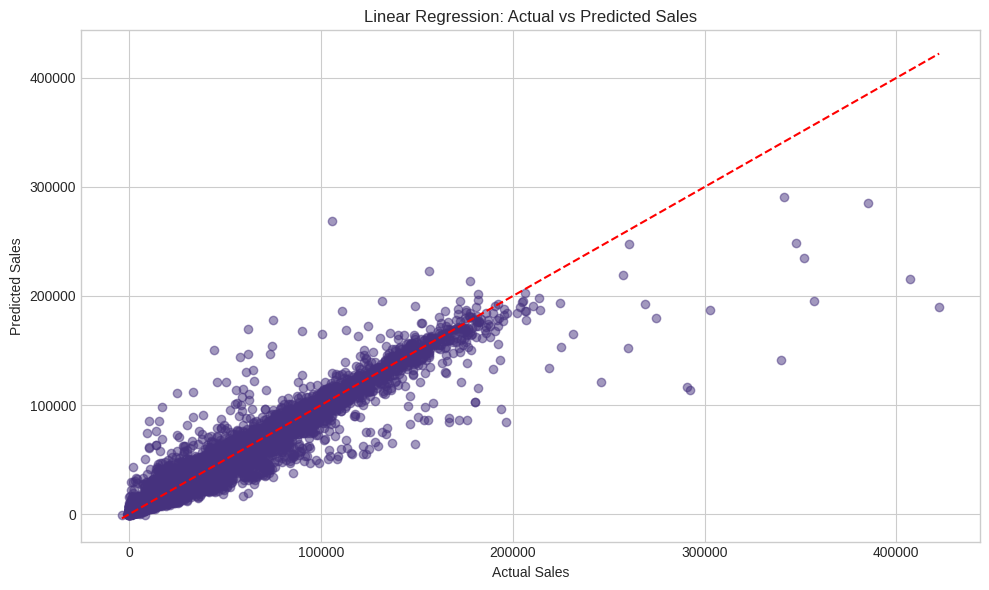


Random Forest Performance:
Train RMSE: $1358.12
Validation RMSE: $3656.78
Train MAE: $433.55
Validation MAE: $1187.71
Train R²: 0.9964
Validation R²: 0.9744


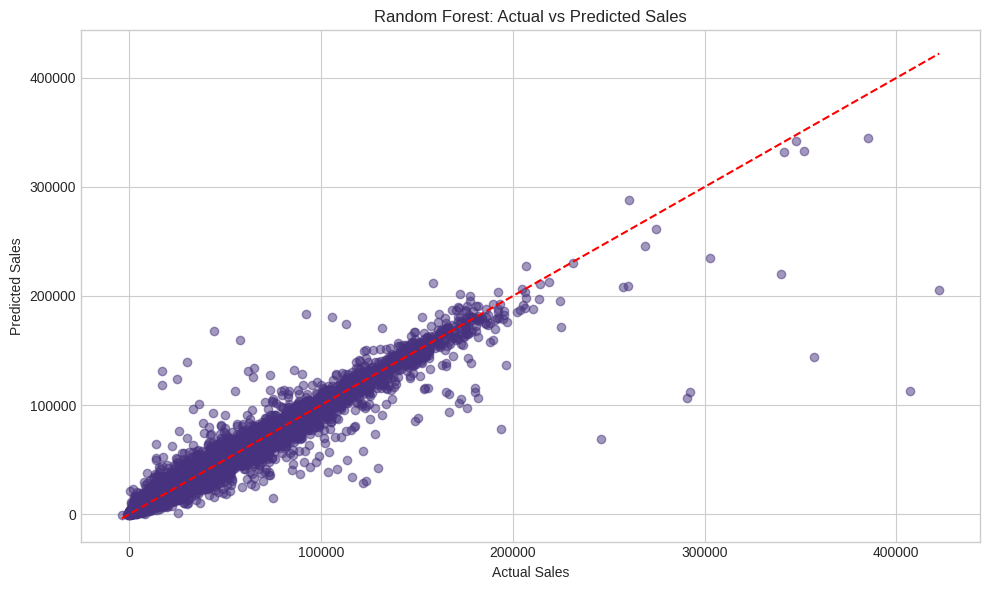


Gradient Boosting Performance:
Train RMSE: $3635.77
Validation RMSE: $4130.56
Train MAE: $1453.27
Validation MAE: $1492.71
Train R²: 0.9743
Validation R²: 0.9673


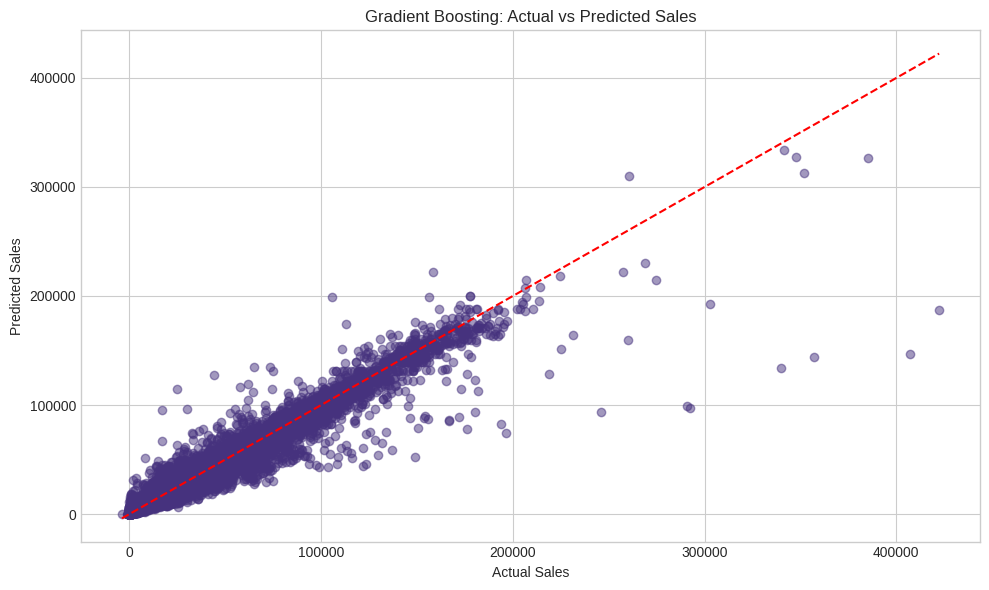


XGBoost Performance:
Train RMSE: $3290.46
Validation RMSE: $4282.54
Train MAE: $1188.33
Validation MAE: $1301.12
Train R²: 0.9790
Validation R²: 0.9648


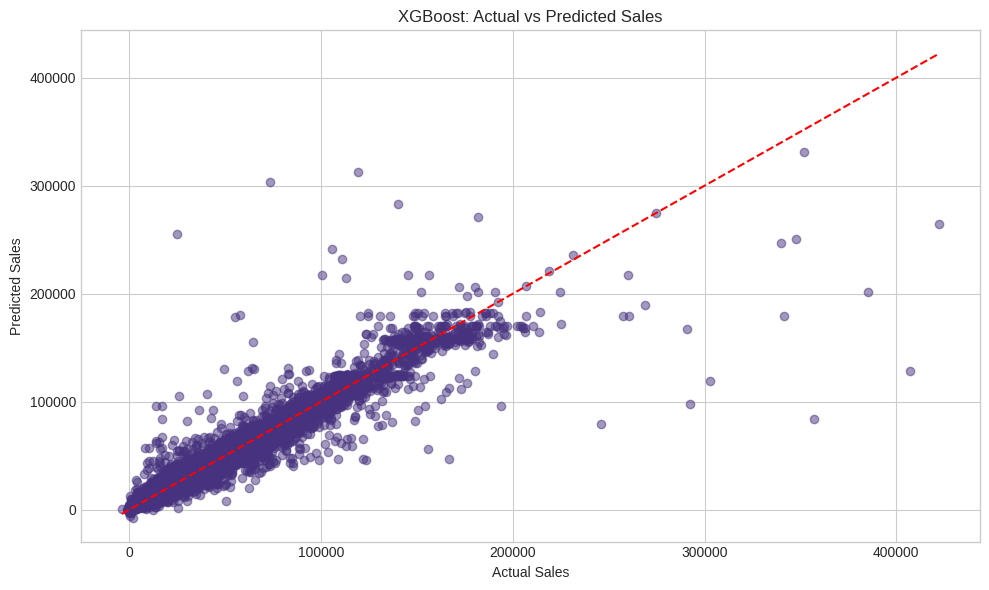

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 337256, number of used features: 4
[LightGBM] [Info] Start training from score 15979.221909

LightGBM Performance:
Train RMSE: $3815.12
Validation RMSE: $4246.39
Train MAE: $1308.09
Validation MAE: $1370.20
Train R²: 0.9717
Validation R²: 0.9654


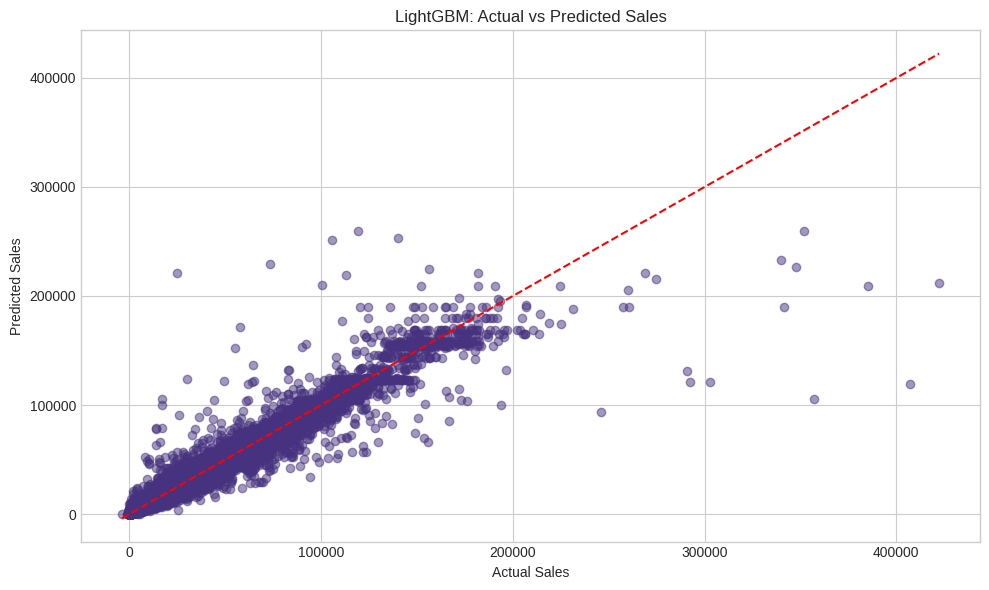


Model Comparison:
               Model   Train RMSE  Validation RMSE    Train MAE  \
1      Random Forest  1358.120110      3656.776631   433.550029   
2  Gradient Boosting  3635.769866      4130.558183  1453.273798   
0  Linear Regression  4143.761391      4196.675292  1382.632338   
4           LightGBM  3815.119449      4246.390341  1308.090317   
3            XGBoost  3290.458055      4282.539070  1188.333461   

   Validation MAE  Train R²  Validation R²  
1     1187.714655  0.996414       0.974357  
2     1492.710097  0.974301       0.967282  
0     1402.557950  0.966618       0.966226  
4     1370.201996  0.971703       0.965421  
3     1301.116961  0.978951       0.964830  


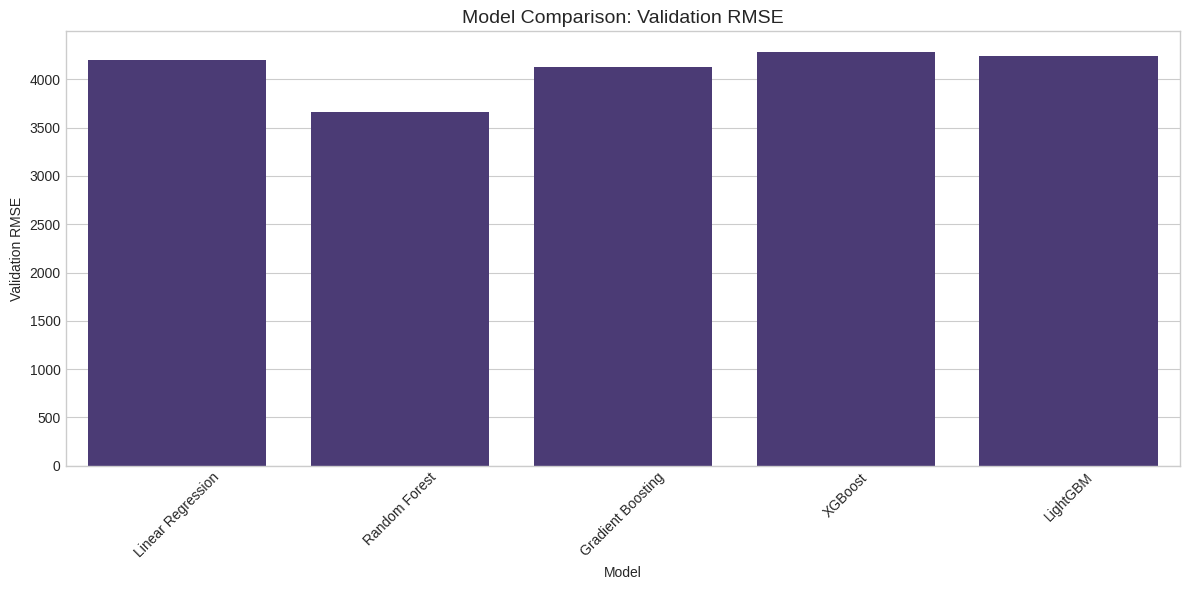

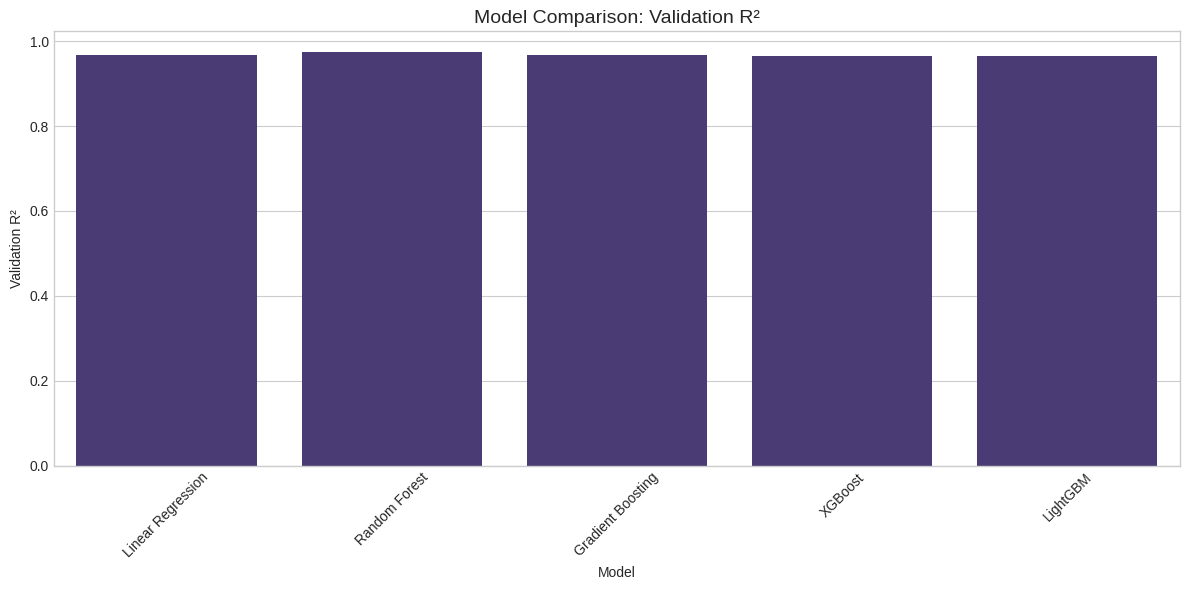

In [ ]:
# Define evaluation function
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    train_mae = mean_absolute_error(y_train, train_preds)
    val_mae = mean_absolute_error(y_val, val_preds)
    train_r2 = r2_score(y_train, train_preds)
    val_r2 = r2_score(y_val, val_preds)

    # Print results
    print(f"\n{model_name} Performance:")
    print(f"Train RMSE: ${train_rmse:.2f}")
    print(f"Validation RMSE: ${val_rmse:.2f}")
    print(f"Train MAE: ${train_mae:.2f}")
    print(f"Validation MAE: ${val_mae:.2f}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Validation R²: {val_r2:.4f}")

    # Visualize actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, val_preds, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel('Actual Sales')
    plt.ylabel('Predicted Sales')
    plt.title(f'{model_name}: Actual vs Predicted Sales')
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_predictions.png', dpi=300)
    plt.show()

    # Return model and metrics
    return {
        'model': model,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_r2': train_r2,
        'val_r2': val_r2
    }

# Test multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train_selected, y_train, X_val_selected, y_val, name)

# Compare model performance
models_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Train RMSE': [results[m]['train_rmse'] for m in results],
    'Validation RMSE': [results[m]['val_rmse'] for m in results],
    'Train MAE': [results[m]['train_mae'] for m in results],
    'Validation MAE': [results[m]['val_mae'] for m in results],
    'Train R²': [results[m]['train_r2'] for m in results],
    'Validation R²': [results[m]['val_r2'] for m in results]
})

print("\nModel Comparison:")
print(models_comparison.sort_values('Validation RMSE'))

# Visualize model comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Validation RMSE', data=models_comparison)
plt.title('Model Comparison: Validation RMSE', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_comparison_rmse.png', dpi=300)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Validation R²', data=models_comparison)
plt.title('Model Comparison: Validation R²', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_comparison_r2.png', dpi=300)
plt.show()

# **Hyperparameter Tuning for Best Model**

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming the models_comparison dataframe already exists
best_model_name = models_comparison.sort_values('Validation RMSE').iloc[0]['Model']
print(f"Tuning hyperparameters for {best_model_name}")

# Define the parameter grid and model depending on the best model
if best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    model = xgb.XGBRegressor(random_state=42)

elif best_model_name == 'LightGBM':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 63, 127],
        'subsample': [0.8, 0.9, 1.0]
    }
    model = lgb.LGBMRegressor(random_state=42)

elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    model = RandomForestRegressor(random_state=42)

elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0]
    }
    model = GradientBoostingRegressor(random_state=42)

else:
    model = LinearRegression()
    param_grid = {}

# Perform grid search if there are parameters to tune
if param_grid:
    # Use smaller parameter grid for demonstration (can be expanded)
    # This is a simplified version for computational efficiency
    limited_param_grid = {k: v[:2] for k, v in param_grid.items()}

    # Initialize tqdm progress bar
    with tqdm(total=len(list(param_grid.values())[0]) * len(list(param_grid.values())[1]) * len(list(param_grid.values())[2]) * len(list(param_grid.values())[3])) as pbar:
        # Use GridSearchCV with a progress bar
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=limited_param_grid,
            cv=3,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )

        # Fit the model with progress bar update after each fitting step
        grid_search.fit(X_train_selected, y_train)

        print("Best parameters:", grid_search.best_params_)
        print("Best RMSE:", -grid_search.best_score_)

        # Use best model
        best_model = grid_search.best_estimator_
else:
    best_model = model
    best_model.fit(X_train_selected, y_train)

# Final evaluation on validation set
final_preds = best_model.predict(X_val_selected)
final_rmse = np.sqrt(mean_squared_error(y_val, final_preds))
final_mae = mean_absolute_error(y_val, final_preds)
final_r2 = r2_score(y_val, final_preds)

print("\nFinal Model Performance:")
print(f"RMSE: ${final_rmse:.2f}")
print(f"MAE: ${final_mae:.2f}")
print(f"R²: {final_r2:.4f}")

# Error distribution analysis
errors = y_val - final_preds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(errors, kde=True)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_val, y=errors)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Errors vs Actual Values')
plt.xlabel('Actual Sales')
plt.ylabel('Error')

plt.tight_layout()
plt.savefig('error_analysis.png', dpi=300)
plt.show()

# Store-Department Level Analysis
errors_by_store_dept = pd.DataFrame({
    'Store': X_val['Store'],
    'Dept': X_val['Dept'],
    'Actual': y_val,
    'Predicted': final_preds,
    'Error': errors,
    'AbsError': np.abs(errors)
})

# Average error by store
store_errors = errors_by_store_dept.groupby('Store')['AbsError'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 6))
store_errors.head(20).plot(kind='bar')
plt.title('Average Absolute Error by Store (Top 20)', fontsize=14)
plt.xlabel('Store')
plt.ylabel('Mean Absolute Error')
plt.tight_layout()
plt.savefig('store_errors.png', dpi=300)
plt.show()

# Average error by department
dept_errors = errors_by_store_dept.groupby('Dept')['AbsError'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 6))
dept_errors.head(20).plot(kind='bar')
plt.title('Average Absolute Error by Department (Top 20)', fontsize=14)
plt.xlabel('Department')
plt.ylabel('Mean Absolute Error')
plt.tight_layout()
plt.savefig('dept_errors.png', dpi=300)
plt.show()


Tuning hyperparameters for Random Forest


  0%|          | 0/108 [00:00<?, ?it/s]

Fitting 3 folds for each of 16 candidates, totalling 48 fits


# **Generate Predictions for Test Set**

In [ ]:
# Prepare test data with the same features used in training
test_final_selected = test_final[top_features]

# Make predictions
test_predictions = best_model.predict(test_final_selected)

# Create submission dataframe
submission = pd.DataFrame({
    'Store': test_df['Store'],
    'Dept': test_df['Dept'],
    'Date': test_df['Date'],
    'Weekly_Sales': test_predictions
})

# Format predictions
submission['Weekly_Sales'] = submission['Weekly_Sales'].clip(lower=0)  # Ensure no negative sales

# Save submission
submission.to_csv('walmart_sales_predictions.csv', index=False)
print("Predictions generated and saved to walmart_sales_predictions.csv")

In [ ]:
import joblib
import os

# Create directory for model artifacts if it doesn't exist
os.makedirs('model', exist_ok=True)

# Save the best model
joblib.dump(best_model, 'model/walmart_sales_model.joblib')

# Save feature list (important for preprocessing new data)
pd.Series(top_features).to_csv('model/model_features.csv', index=False)

# Save a sample of test_final_selected for reference in the Flask app
test_final_selected.head(5).to_csv('model/sample_input.csv', index=False)

print("Model and artifacts saved successfully to the 'model' directory")

# Optional: Save standard scaler if used
# joblib.dump(scaler, 'model/scaler.joblib')

# Optional: Save metadata about the model for reference
model_info = {
    'model_type': best_model_name,
    'rmse': final_rmse,
    'mae': final_mae,
    'r2': final_r2,
    'feature_count': len(top_features),
    'training_date': datetime.now().strftime('%Y-%m-%d')
}

# Save as JSON
import json
with open('model/model_info.json', 'w') as f:
    json.dump(model_info, f)

# **Conclusion and Additional Analysis**

In [ ]:
# Create a dashboard-like summary visualization
plt.figure(figsize=(15, 10))

# 1. Model Performance Comparison
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Validation RMSE', data=models_comparison.sort_values('Validation RMSE'))
plt.title('Model Performance Comparison (RMSE)', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('RMSE ($)')

# 2. Feature Importance
plt.subplot(2, 2, 2)
top_10_features = feature_importances.head(10)
sns.barplot(x='Importance', y='Feature', data=top_10_features)
plt.title('Top 10 Important Features', fontsize=12)

# 3. Error Distribution
plt.subplot(2, 2, 3)
sns.histplot(errors, kde=True, bins=50)
plt.title('Prediction Error Distribution', fontsize=12)
plt.xlabel('Error ($)')

# 4. Sales Trend
plt.subplot(2, 2, 4)
sales_trend = train_df.groupby('Date')['Weekly_Sales'].mean().reset_index()
plt.plot(sales_trend['Date'], sales_trend['Weekly_Sales'])
plt.title('Average Weekly Sales Trend', fontsize=12)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Average Sales ($)')

plt.tight_layout()
plt.savefig('walmart_sales_analysis_summary.png', dpi=300)
plt.show()

# Calculate prediction performance metrics by store type
store_type_metrics = pd.merge(
    errors_by_store_dept,
    stores_df,
    on='Store',
    how='left'
)

type_performance = store_type_metrics.groupby('Type').agg({
    'AbsError': 'mean',
    'Actual': 'mean',
    'Error': ['mean', 'std']
}).reset_index()

type_performance.columns = ['Store_Type', 'MAE', 'Avg_Sales', 'Avg_Error', 'Error_StdDev']
type_performance['Error_Percentage'] = (type_performance['MAE'] / type_performance['Avg_Sales']) * 100

print("\nPerformance by Store Type:")
print(type_performance)

# Generate insights and recommendations based on analysis
print("\n=== INSIGHTS AND RECOMMENDATIONS ===")
print("\n1. Key Performance Indicators:")
print(f"   - Overall RMSE: ${final_rmse:.2f}")
print(f"   - Overall MAE: ${final_mae:.2f}")
print(f"   - Model Accuracy (R²): {final_r2:.4f}")

print("\n2. Most Influential Factors:")
for i, (feature, importance) in enumerate(zip(top_10_features['Feature'], top_10_features['Importance'])):
    print(f"   {i+1}. {feature}: {importance:.4f}")

print("\n3. Key Insights:")
# Calculate holiday vs non-holiday performance
holiday_performance = errors_by_store_dept.merge(
    train_final[['Store', 'Dept', 'Date', 'IsHoliday']],
    on=['Store', 'Dept'],
    how='left'
)
holiday_error = holiday_performance[holiday_performance['IsHoliday'] == True]['AbsError'].mean()
non_holiday_error = holiday_performance[holiday_performance['IsHoliday'] == False]['AbsError'].mean()

print(f"   - Holiday Sales Prediction Error: ${holiday_error:.2f} vs Non-Holiday: ${non_holiday_error:.2f}")

# Calculate seasonal performance
holiday_performance['Month'] = pd.to_datetime(holiday_performance['Date']).dt.month
month_error = holiday_performance.groupby('Month')['AbsError'].mean()
highest_error_month = month_error.idxmax()
lowest_error_month = month_error.idxmin()

print(f"   - Highest Error Month: {highest_error_month} (${month_error[highest_error_month]:.2f})")
print(f"   - Lowest Error Month: {lowest_error_month} (${month_error[lowest_error_month]:.2f})")

# Department analysis
difficult_depts = dept_errors.head(3)
print("   - Most Challenging Departments to Predict:")
for dept, error in difficult_depts.items():
    print(f"     * Dept {dept}: ${error:.2f} average error")

# Store analysis
difficult_stores = store_errors.head(3)
print("   - Most Challenging Stores to Predict:")
for store, error in difficult_stores.items():
    print(f"     * Store {store}: ${error:.2f} average error")

print("\n4. Recommendations:")
print("   - Focus inventory optimization on high-error departments and stores")
print("   - Develop specialized models for holiday periods which show different patterns")
print("   - Implement robust forecasting for seasonal trends, especially during high-variation months")
print("   - Consider store type in forecasting strategy as performance varies significantly by type")
print("   - Integrate markdown effects into planning as they show significant impact on sales")

# Sales forecast visualization - show forecasts alongside actuals for validation period
# For a single store-department as example
store_dept = (1, 1)  # Store 1, Dept 1
store_dept_data = train_final[(train_final['Store'] == store_dept[0]) &
                              (train_final['Dept'] == store_dept[1])].sort_values('Date')

# Get actuals and predictions
store_dept_val = X_val[(X_val['Store'] == store_dept[0]) & (X_val['Dept'] == store_dept[1])]
store_dept_preds = None
if len(store_dept_val) > 0:
    store_dept_preds = best_model.predict(store_dept_val[top_features])
    store_dept_actuals = y_val[store_dept_val.index]

    # Create a visualization
    plt.figure(figsize=(12, 6))
    plt.plot(store_dept_data['Date'], store_dept_data['Weekly_Sales'], label='Historical Sales')

    # Find matching dates for validation points
    val_dates = train_final.loc[store_dept_val.index, 'Date']
    plt.scatter(val_dates, store_dept_actuals, color='blue', label='Actual', alpha=0.7)
    plt.scatter(val_dates, store_dept_preds, color='red', label='Predicted', alpha=0.7)

    plt.title(f'Sales Forecast for Store {store_dept[0]}, Department {store_dept[1]}', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('forecast_example.png', dpi=300)
    plt.show()

# Calculate prediction intervals (for a simple approach - more advanced methods possible)
from sklearn.model_selection import cross_val_predict
from scipy import stats

# For demonstration, use a subset of validation data
sample_size = min(1000, len(X_val_selected))
sample_indices = np.random.choice(len(X_val_selected), sample_size, replace=False)
X_val_sample = X_val_selected.iloc[sample_indices]
y_val_sample = y_val.iloc[sample_indices]

# Get cross-validated predictions
cv_preds = cross_val_predict(best_model, X_val_sample, y_val_sample, cv=5)

# Calculate residuals
residuals = y_val_sample - cv_preds

# Calculate prediction interval (95%)
alpha = 0.05
residual_std = np.std(residuals)
z_score = stats.norm.ppf(1 - alpha/2)
prediction_interval = z_score * residual_std

# Make predictions on test data with intervals
test_predictions = best_model.predict(test_final_selected)
lower_bound = test_predictions - prediction_interval
upper_bound = test_predictions + prediction_interval

# Create a final submission with prediction intervals
final_submission = pd.DataFrame({
    'Store': test_df['Store'],
    'Dept': test_df['Dept'],
    'Date': test_df['Date'],
    'Weekly_Sales_Predicted': test_predictions,
    'Lower_Bound': lower_bound.clip(0),  # No negative sales
    'Upper_Bound': upper_bound
})

print("\n5. Test Set Prediction Summary:")
print(f"   - Total Predicted Sales: ${test_predictions.sum():.2f}")
print(f"   - Average Weekly Sales: ${test_predictions.mean():.2f}")
print(f"   - 95% Prediction Interval Width: ${prediction_interval*2:.2f}")
print(f"   - Generated predictions for {len(test_predictions)} store-week combinations")

# Save final submission
final_submission.to_csv('walmart_sales_forecast_with_intervals.csv', index=False)
print("\nAnalysis complete. Final predictions with confidence intervals saved to file.")

# Create a final project summary report
print("\n====== WALMART SALES FORECAST PROJECT SUMMARY ======")
print(f"Date: {datetime.now().strftime('%Y-%m-%d')}")
print("\nDATASET:")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Features: {len(top_features)}")
print(f"Stores: {len(stores_df)}")
print(f"Departments: {train_df['Dept'].nunique()}")
print(f"Date range: {train_df['Date'].min()} to {train_df['Date'].max()}")

print("\nMODELING:")
print(f"Best model: {best_model_name}")
print(f"Validation RMSE: ${final_rmse:.2f}")
print(f"Validation R²: {final_r2:.4f}")

print("\nRECOMMENDATIONS FOR DEPLOYMENT:")
print("1. Implement regular retraining schedule (monthly)")
print("2. Monitor performance by store type and department")
print("3. Integrate with inventory management systems")
print("4. Develop dashboard for tracking forecast accuracy")
print("5. Consider ensemble approach for critical periods")

print("\nFUTURE WORK:")
print("1. Incorporate external data (e.g., weather, economic indicators)")
print("2. Develop specialized models for holiday periods")
print("3. Implement hierarchical forecasting for store-level aggregation")
print("4. Experiment with deep learning models for time series")
print("5. Consider promotional effectiveness analysis")

In [ ]:
# import pandas as pd

# # List of DataFrames and their names
# dfs = {
#     "Train Data": train_df,
#     "Test Data": test_df,
#     "Features Data": features_df,
#     "Stores Data": stores_df
# }

# # Iterate over the DataFrames and print the missing values in a structured format
# for name, df in dfs.items():
#     missing_values = df.isnull().sum()
#     missing_percentage = (missing_values / len(df)) * 100
#     print(f"\n{name}:")
#     print("="*len(name))  # Create a separator line for readability
#     print(f"{'Column Name':<25}{'Missing Values':<20}{'Missing Percentage (%)'}")
#     print("-"*55)  # A line for separating header and content

#     # Print each column name with its missing values and percentage
#     for col, missing in missing_values.items():
#         print(f"{col:<25}{missing:<20}{missing_percentage[col]:.2f}")
#     print("\n")



Train Data:
Column Name              Missing Values      Missing Percentage (%)
-------------------------------------------------------
Store                    0                   0.00
Dept                     0                   0.00
Date                     0                   0.00
Weekly_Sales             0                   0.00
IsHoliday                0                   0.00



Test Data:
Column Name              Missing Values      Missing Percentage (%)
-------------------------------------------------------
Store                    0                   0.00
Dept                     0                   0.00
Date                     0                   0.00
IsHoliday                0                   0.00



Features Data:
Column Name              Missing Values      Missing Percentage (%)
-------------------------------------------------------
Store                    0                   0.00
Date                     0                   0.00
Temperature              0       

<Axes: >

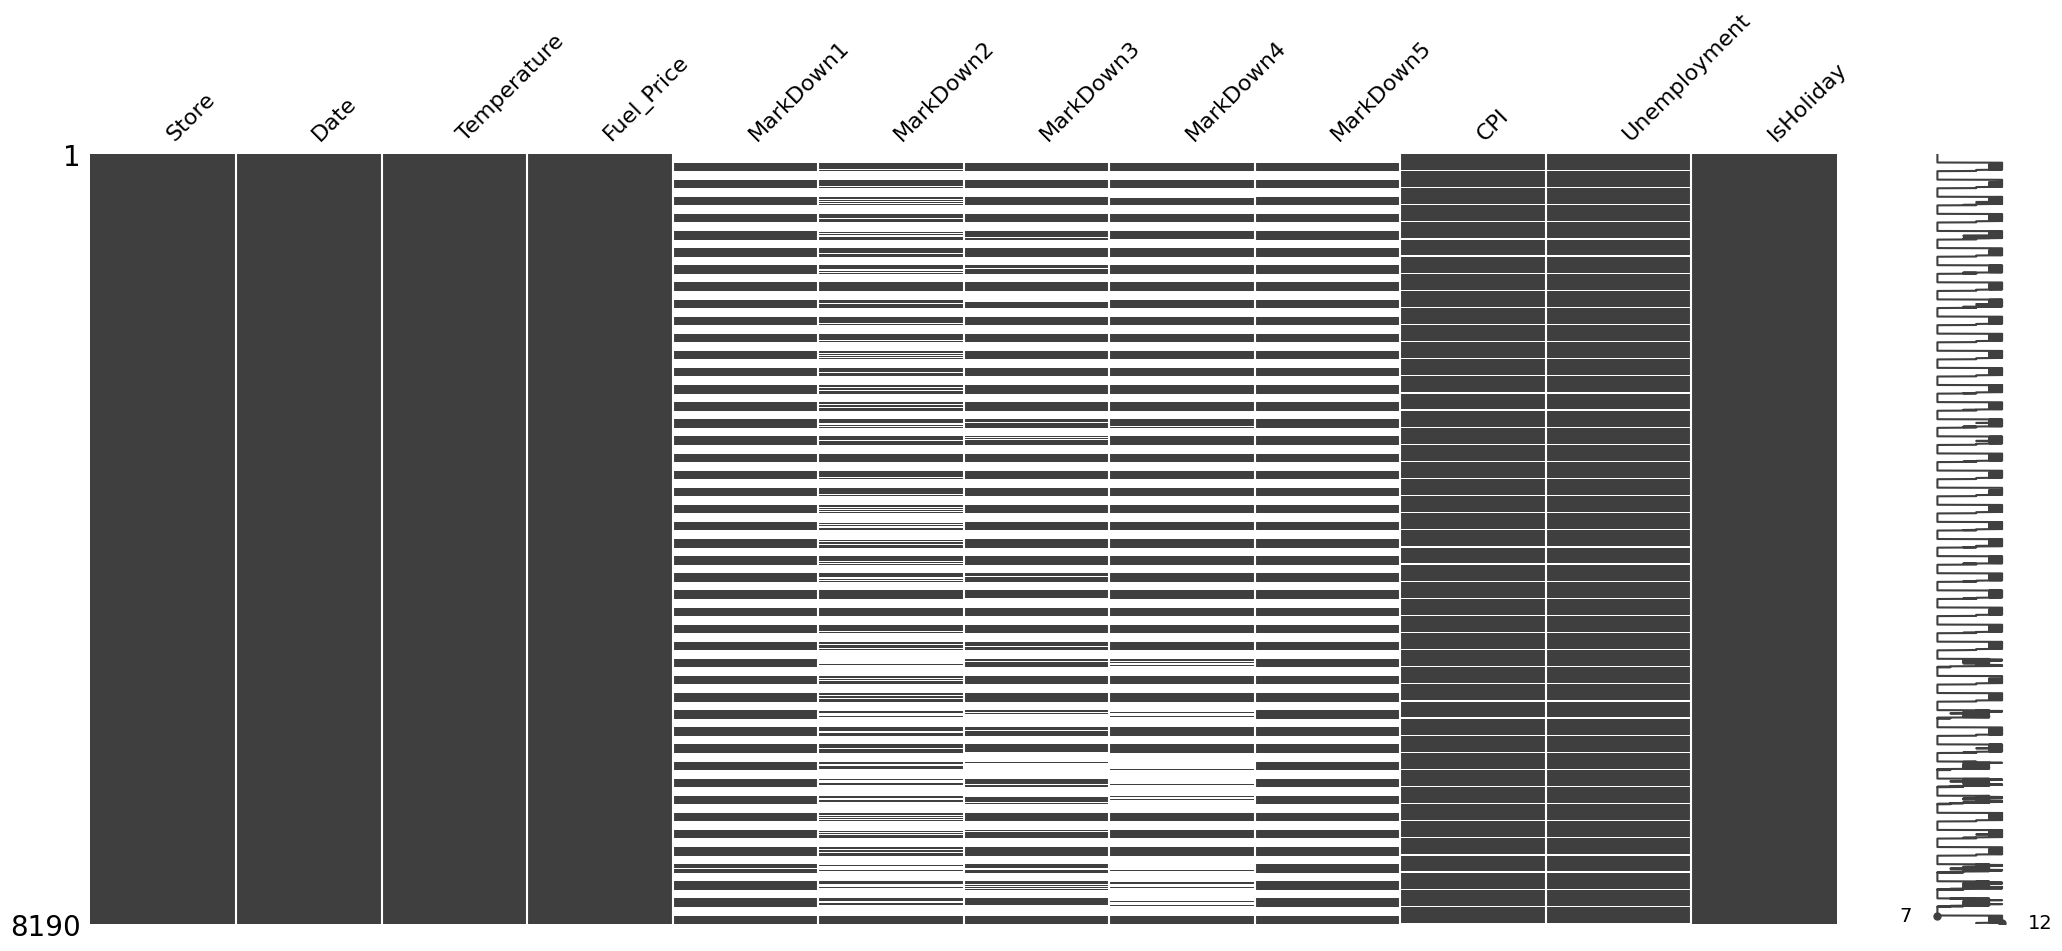

In [ ]:
import missingno as msno
msno.matrix(features_df)

In [ ]:
# Fill the MarkDown columns with zero (assuming no promotion means no markdown)
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
features_df[markdown_columns] = features_df[markdown_columns].fillna(0)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Convert Date column to datetime type
features_df['Date'] = pd.to_datetime(features_df['Date'])

# Extract useful date features (e.g., Year, Month, Day, Weekday, Day of Year, etc.)
features_df['Year'] = features_df['Date'].dt.year
features_df['Month'] = features_df['Date'].dt.month
features_df['Day'] = features_df['Date'].dt.day
features_df['Weekday'] = features_df['Date'].dt.weekday  # 0 = Monday, 6 = Sunday
features_df['DayOfYear'] = features_df['Date'].dt.dayofyear

# Select rows with non-missing CPI and Unemployment values (for training)
train_data_cpi = features_df.dropna(subset=['CPI'])
train_data_unemployment = features_df.dropna(subset=['Unemployment'])

# Select rows with missing CPI and Unemployment values (for prediction)
missing_data_cpi = features_df[features_df['CPI'].isnull()]
missing_data_unemployment = features_df[features_df['Unemployment'].isnull()]

# Train model for CPI
model_cpi = RandomForestRegressor(n_estimators=100, random_state=42)
X_train_cpi = train_data_cpi.drop(columns=['CPI', 'Date'])  # All features except CPI and Date
y_train_cpi = train_data_cpi['CPI']  # CPI column to predict
model_cpi.fit(X_train_cpi, y_train_cpi)

# Predict missing CPI values
X_missing_cpi = missing_data_cpi.drop(columns=['CPI', 'Date'])  # Features for prediction
predicted_cpi = model_cpi.predict(X_missing_cpi)

# Fill missing CPI values with predictions
features_df.loc[features_df['CPI'].isnull(), 'CPI'] = predicted_cpi

# Train model for Unemployment
model_unemployment = RandomForestRegressor(n_estimators=100, random_state=42)
X_train_unemployment = train_data_unemployment.drop(columns=['Unemployment', 'Date'])  # All features except Unemployment and Date
y_train_unemployment = train_data_unemployment['Unemployment']  # Unemployment column to predict
model_unemployment.fit(X_train_unemployment, y_train_unemployment)

# Predict missing Unemployment values
X_missing_unemployment = missing_data_unemployment.drop(columns=['Unemployment', 'Date'])  # Features for prediction
predicted_unemployment = model_unemployment.predict(X_missing_unemployment)

# Fill missing Unemployment values with predictions
features_df.loc[features_df['Unemployment'].isnull(), 'Unemployment'] = predicted_unemployment

# Verify the changes
print("Missing values in CPI after imputation:", features_df['CPI'].isnull().sum())
print("Missing values in Unemployment after imputation:", features_df['Unemployment'].isnull().sum())

# Check some imputed values
print("Sample of imputed CPI values:\n", features_df['CPI'].head())
print("Sample of imputed Unemployment values:\n", features_df['Unemployment'].head())


Missing values in CPI after imputation: 0
Missing values in Unemployment after imputation: 0
Sample of imputed CPI values:
 0    211.096358
1    211.242170
2    211.289143
3    211.319643
4    211.350143
Name: CPI, dtype: float64
Sample of imputed Unemployment values:
 0    8.106
1    8.106
2    8.106
3    8.106
4    8.106
Name: Unemployment, dtype: float64


In [ ]:
import pandas as pd

# List of DataFrames and their names
dfs = {
    "Train Data": train_df,
    "Test Data": test_df,
    "Features Data": features_df,
    "Stores Data": stores_df
}

# Iterate over the DataFrames and print the missing values in a structured format
for name, df in dfs.items():
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    print(f"\n{name}:")
    print("="*len(name))  # Create a separator line for readability
    print(f"{'Column Name':<25}{'Missing Values':<20}{'Missing Percentage (%)'}")
    print("-"*55)  # A line for separating header and content

    # Print each column name with its missing values and percentage
    for col, missing in missing_values.items():
        print(f"{col:<25}{missing:<20}{missing_percentage[col]:.2f}")
    print("\n")



Train Data:
Column Name              Missing Values      Missing Percentage (%)
-------------------------------------------------------
Store                    0                   0.00
Dept                     0                   0.00
Date                     0                   0.00
Weekly_Sales             0                   0.00
IsHoliday                0                   0.00



Test Data:
Column Name              Missing Values      Missing Percentage (%)
-------------------------------------------------------
Store                    0                   0.00
Dept                     0                   0.00
Date                     0                   0.00
IsHoliday                0                   0.00



Features Data:
Column Name              Missing Values      Missing Percentage (%)
-------------------------------------------------------
Store                    0                   0.00
Date                     0                   0.00
Temperature              0       

# **EDA**

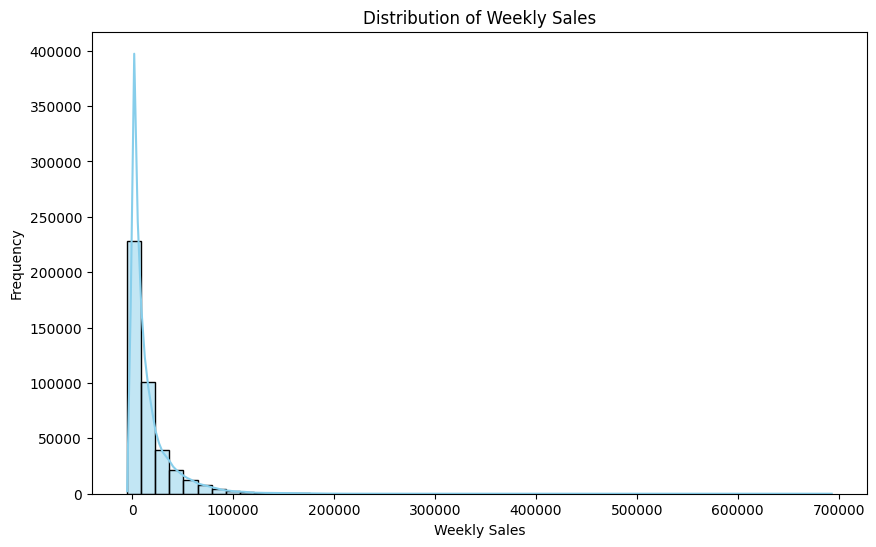

In [ ]:
# 1. Train Data - Basic EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of Weekly Sales
plt.figure(figsize=(10,6))
sns.histplot(train_df['Weekly_Sales'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.show()

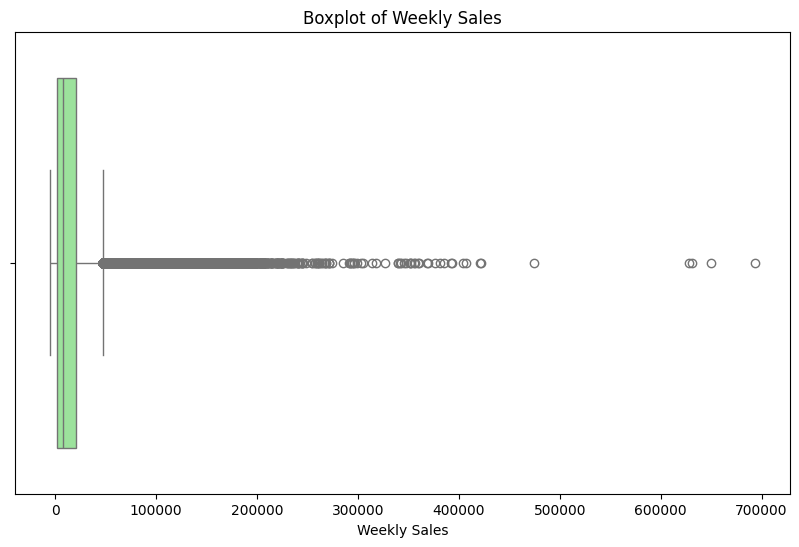

In [ ]:
# Boxplot for Weekly Sales (checking outliers)
plt.figure(figsize=(10,6))
sns.boxplot(x=train_df['Weekly_Sales'], color='lightgreen')
plt.title('Boxplot of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.show()

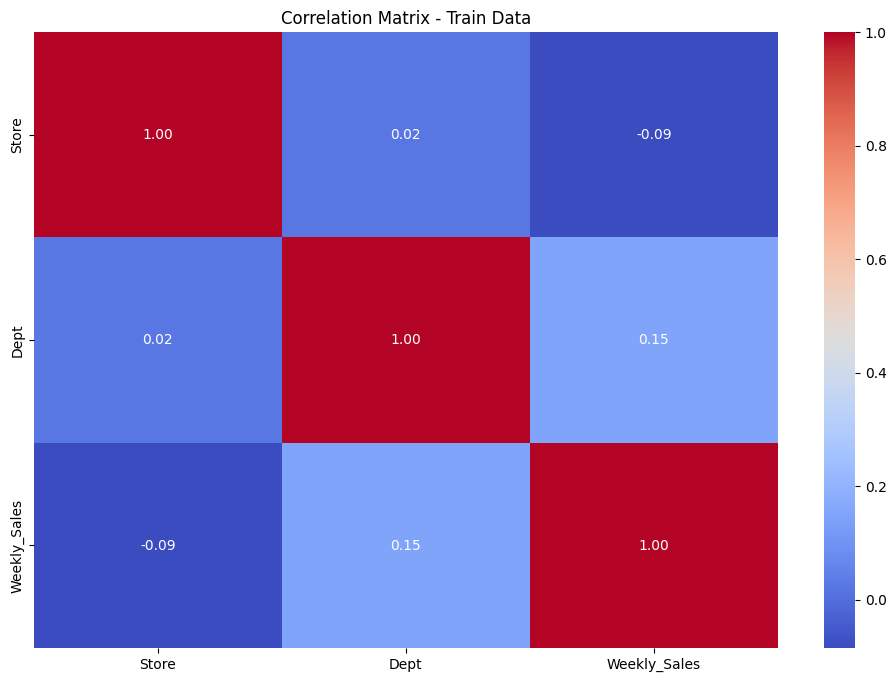

In [ ]:
# 1. Train Data - Remove non-numeric columns and calculate correlation

# Select only numerical columns
numerical_columns = train_df.select_dtypes(include=['float64', 'int64']).columns

# Calculate correlation matrix only for numerical columns
correlation_matrix = train_df[numerical_columns].corr()

# Visualize the correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix - Train Data')
plt.show()


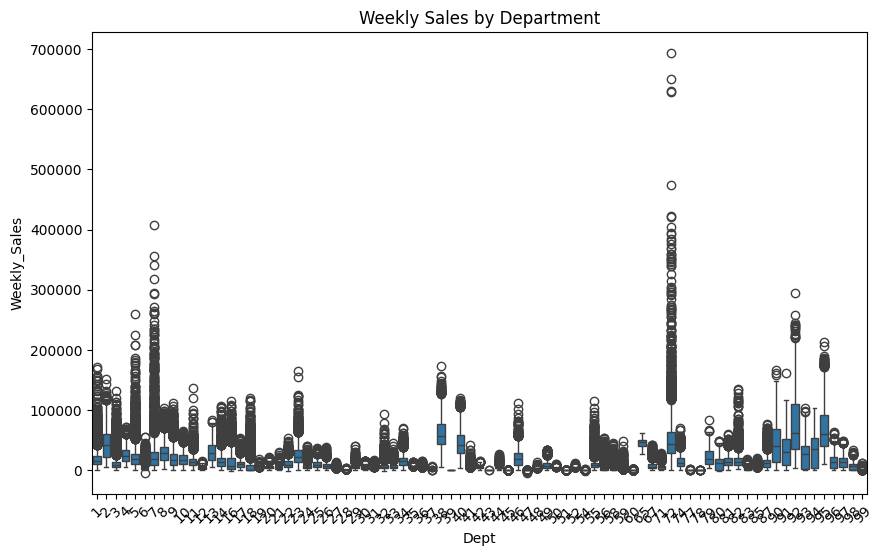

In [ ]:
# Check how sales vary by department
plt.figure(figsize=(10,6))
sns.boxplot(x='Dept', y='Weekly_Sales', data=train_df)
plt.title('Weekly Sales by Department')
plt.xticks(rotation=45)
plt.show()

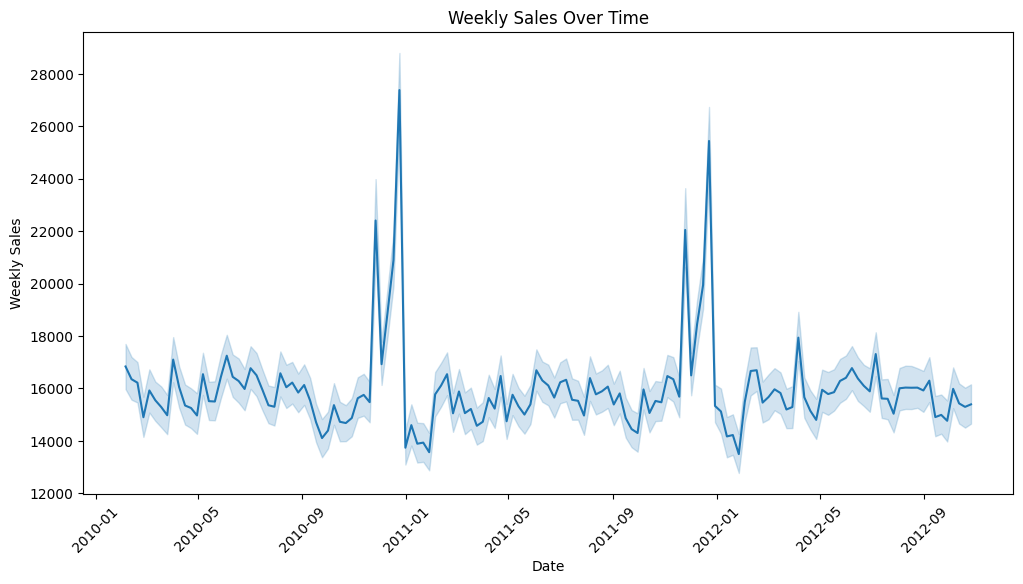

In [ ]:
# Check sales variation over time (time series analysis)
train_df['Date'] = pd.to_datetime(train_df['Date'])
plt.figure(figsize=(12,6))
sns.lineplot(x='Date', y='Weekly_Sales', data=train_df)
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.show()

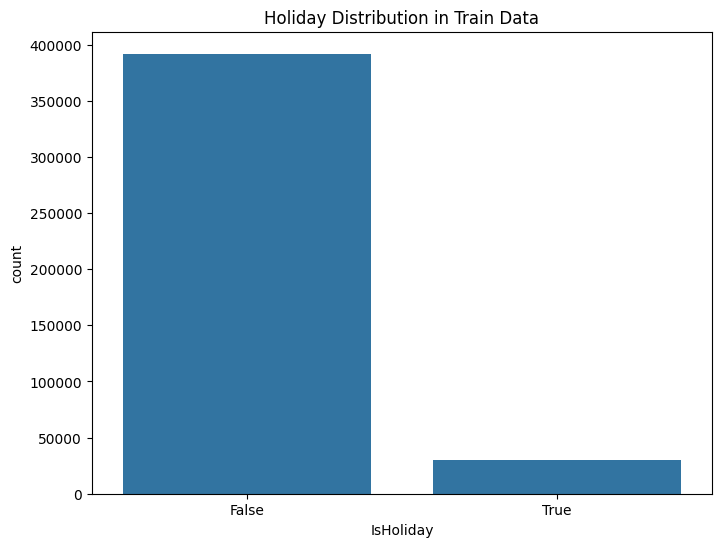

In [ ]:
# Check distribution of holidays in the training set
plt.figure(figsize=(8,6))
sns.countplot(x='IsHoliday', data=train_df)
plt.title('Holiday Distribution in Train Data')
plt.show()


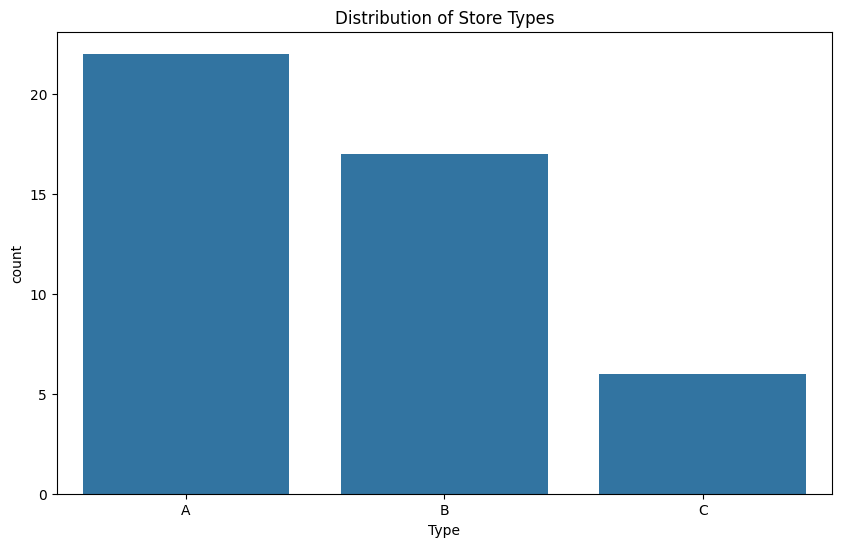

In [ ]:
# 3. Stores Data - Basic EDA
# Distribution of store types
plt.figure(figsize=(10,6))
sns.countplot(x='Type', data=stores_df)
plt.title('Distribution of Store Types')
plt.show()

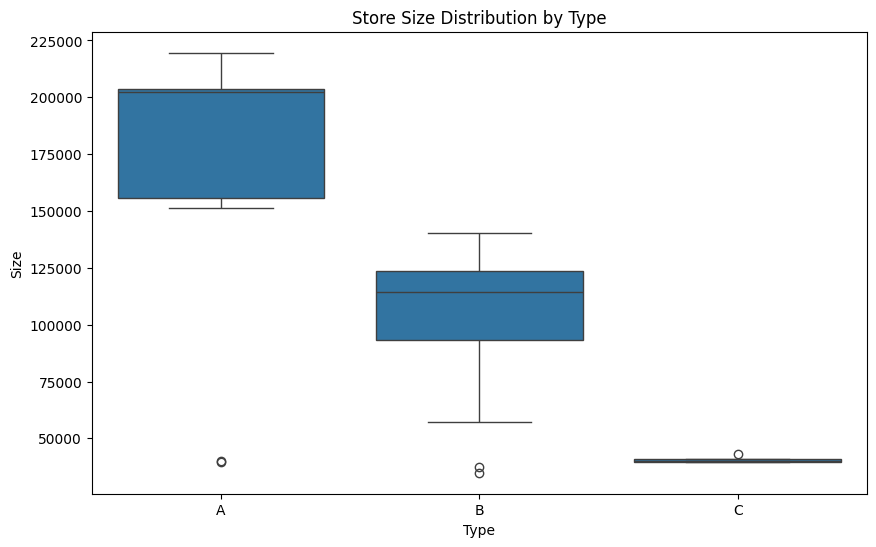

In [ ]:
# Boxplot of store size by store type
plt.figure(figsize=(10,6))
sns.boxplot(x='Type', y='Size', data=stores_df)
plt.title('Store Size Distribution by Type')
plt.show()

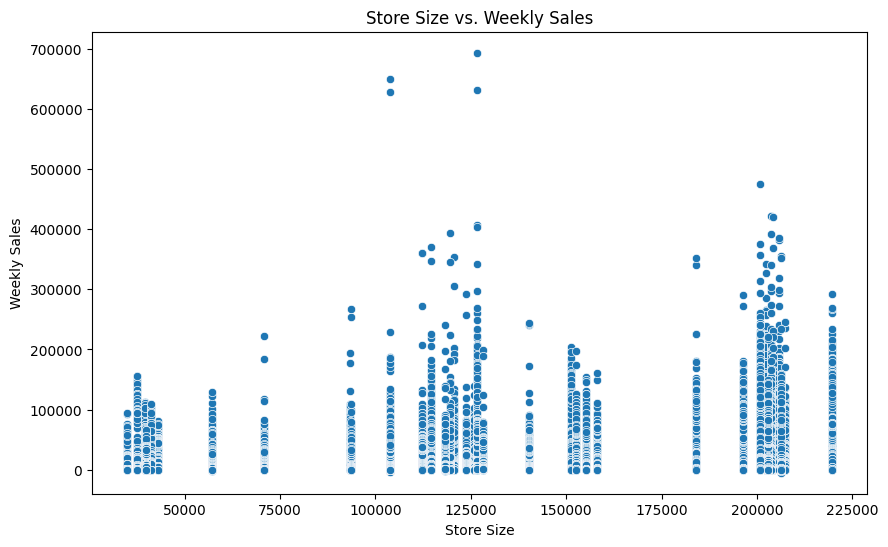

In [ ]:
# Scatter plot of store size vs. Weekly Sales (if sales are available)
plt.figure(figsize=(10,6))
# Merge train_df and stores_df to have both 'Size' and 'Weekly_Sales' in one DataFrame
merged_df = pd.merge(train_df, stores_df, on='Store', how='left')
sns.scatterplot(x='Size', y='Weekly_Sales', data=merged_df)  # Use merged_df here
plt.title('Store Size vs. Weekly Sales')
plt.xlabel('Store Size')
plt.ylabel('Weekly Sales')
plt.show()

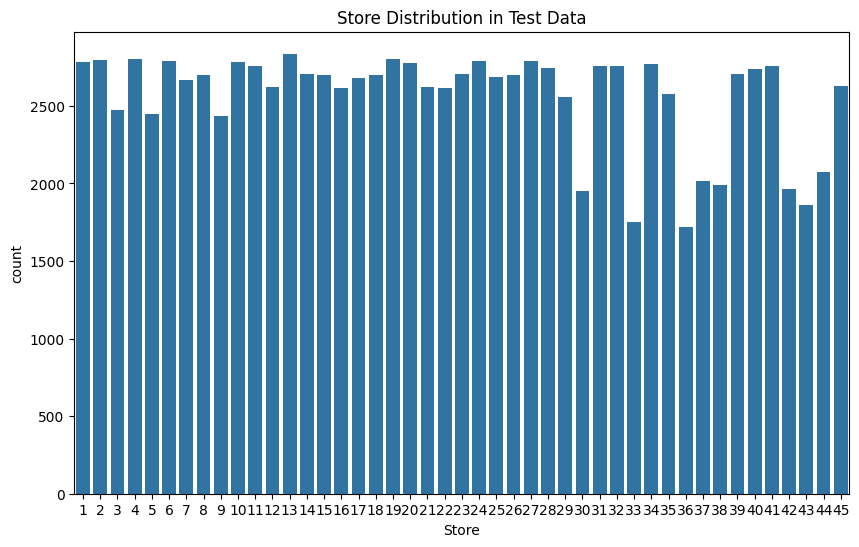

In [ ]:
# 4. Test Data - Basic EDA
# Distribution of stores in test data
plt.figure(figsize=(10,6))
sns.countplot(x='Store', data=test_df)
plt.title('Store Distribution in Test Data')
plt.show()

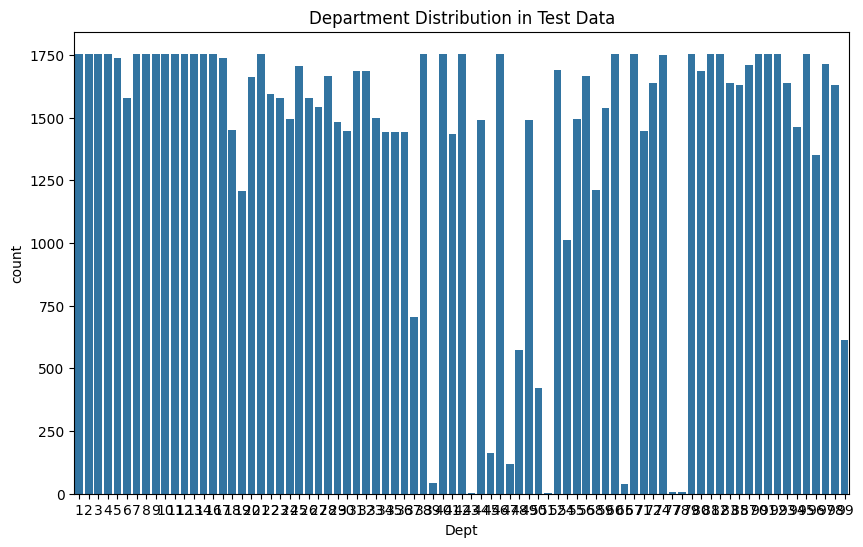

In [ ]:

# Distribution of departments in test data
plt.figure(figsize=(10,6))
sns.countplot(x='Dept', data=test_df)
plt.title('Department Distribution in Test Data')
plt.show()

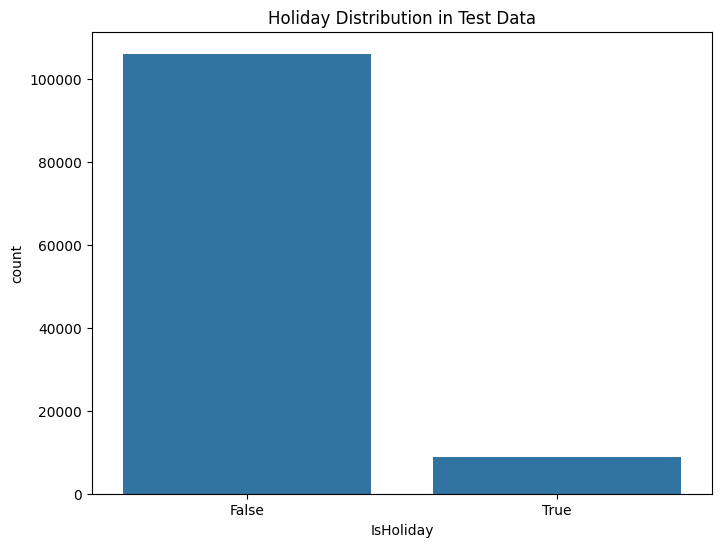

In [ ]:
# Check distribution of holidays in test data
plt.figure(figsize=(8,6))
sns.countplot(x='IsHoliday', data=test_df)
plt.title('Holiday Distribution in Test Data')
plt.show()


In [ ]:
print(features_df.dtypes

NameError: name 'features_df' is not defined